In [1]:
import numpy as np
import pandas as pd
import math as e
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import random
import math

Inputs:  

------------------------------------
- x: Training Dataframe.
- gradient: Gradient of the loss function.
- hessian: Second order derivative of the loss function.
- idxs: Used to keep track of samples within the tree structure.
- subsample_cols: Controls the subsampling of columns (features) during each boosting iteration.
- min_leaf: Minimum number of samples for a node to be considered a node.
- min_child_weight: Sum of the heassian inside a node is a meaure of purity.
- depth: Limits the height of a tree to prevent overfitting.
- lambda: L2 regularization term on weights. Increasing this value will make model more conservative.
- gamma: Used for pruning. This parameter also prevents over fitting and is present in the the calculation of the gain (structure-score). As this is subtracted from the gain it essentially sets a minimum gain amount to make a split in a node. 
- eps: This parameter is used in the quantile weighted sketch.
- split_tye: The type of split we intend to use to identify candidate values for splitting.
- learning_rate_methods: Type of learning rate to be used to assign weight to the predictions of boosted trees.
------------------------------------

### XGBOOST TREE NODES
A node is a fundamental unit of the regression tree.  
It uses internal gain based on hessain and gradient to calculate the best split.  
A weighted quantile sketch is used to help in creating nodes and leaf values are caclulated based on Loss function.  

Output: Tree Object.

In [2]:
class Node:
    def __init__(self,x,gradient,hessian,idxs,subsample_cols = 1, min_leaf = 1, min_child_weight = 1, 
                 depth = 2, lambda_ = 1, gamma = 1, eps = 0.01,
                 split_type = "greedy"):
        self.x = x
        self.gradient = gradient
        self.hessian = hessian
        self.idxs = idxs
        self.subsample_cols = subsample_cols
        self.min_leaf = min_leaf
        self.min_child_weight = min_child_weight
        self.depth = depth
        self.lambda_ = lambda_
        self.gamma = gamma
        self.eps = eps
        self.rows_cnt = len(idxs)
        self.col_count = x.shape[1]
        self.split_type = split_type
        
        # Select a subspace of attributes.
        self.column_subsample = np.random.permutation(self.col_count)[:round(self.subsample_cols*self.col_count)]
        
        self.val = self.calc_val(self.gradient[self.idxs],self.hessian[self.idxs])
        
        self.score = float('-inf')
        self.find_split()
        
    def calc_val(self,gradient,hessian):
        # Calculate the optimal value of a leaf.
        value = np.sum(gradient)/(np.sum(hessian)+self.lambda_)
        value = value*-1
        return value

    def find_split(self):
        # Scans through every column & calculates the best split point. If node is split, 
        # two other nodes are created accordingly. If no split is better then we just return 
        # without making splits.
        
        if(self.split_type == "greedy"):
            for col in self.column_subsample:
                self.find_greedy_split(col)
        elif (self.split_type == "approximate"):
            for col in self.column_subsample:
                self.find_approx_split(col)
            
                
        if (self.is_leaf()):
            return
        
        split_col = self.split_col()
        
        lhs = np.nonzero(split_col <= self.split)[0]
        rhs = np.nonzero(split_col > self.split)[0]
        
        
        self.lhs = Node(x = self.x, gradient= self.gradient, hessian = self.hessian, idxs = self.idxs[lhs],
                        min_leaf= self.min_leaf, depth = self.depth - 1, lambda_= self.lambda_, 
                        min_child_weight = self.min_child_weight, eps = self.eps, 
                        subsample_cols = self.subsample_cols)
        
        self.rhs = Node(x = self.x, gradient= self.gradient, hessian = self.hessian, idxs = self.idxs[rhs],
                        min_leaf= self.min_leaf, depth = self.depth - 1, lambda_= self.lambda_, 
                        min_child_weight = self.min_child_weight, eps = self.eps, 
                        subsample_cols = self.subsample_cols)
    
    def find_greedy_split(self,col):
        # For the given attribute 'col' we try to calculate the best possible split.
        # Globally updates the best score and split point if a better split point is found.
        
        x = self.x.values[self.idxs, col]   # returns numpy array of values of 'col' at certain indices
        
        
        for r in range(0,self.rows_cnt):
            lhs = x <= x[r]
            rhs = x > x[r]
            
            lhs_indices = np.nonzero(x <= x[r])[0]            
            rhs_indices = np.nonzero(x > x[r])[0]
            
            if(len(lhs_indices) < self.min_leaf or len(rhs_indices) < self.min_leaf or
               self.hessian[self.idxs][lhs_indices].sum() < self.min_child_weight or 
               self.hessian[self.idxs][rhs_indices].sum() < self.min_child_weight):
                continue
            
            poss_score = self.gain(lhs_indices,rhs_indices)
            
            if poss_score > self.score:
                self.col = col
                self.score = poss_score
                self.split = x[r]
    
    def find_approx_split(self, col):
        x = self.x.values[self.idxs, col]
        hessian_ = self.hessian[self.idxs]
        df = pd.DataFrame({'Feature': x, 'hess': hessian_, 'id': list(range(len(self.idxs)))})
        df.sort_values(by=['Feature'], ascending=True, inplace=True)
        df.reset_index(inplace=True)
        hess_sum = df['hess'].sum()
        df['rank'] = df.apply(lambda x: (sum(df[df['Feature'] <= x['Feature']]['hess'])) / hess_sum, axis=1)

        prev_idx = 0
        bins_done = 0
        prev_rank = 0
        total_bins = int(1 / self.eps)

        for i in range(0, len(df)):
            if (np.abs(df.loc[i, 'rank'] - prev_rank) >= self.eps):
                new_df = df[prev_idx:i]
                new_df.reset_index(inplace=True)
                prev_idx = i
                bins_done += 1
                self.solve_bin(new_df,col)

            if (bins_done >= total_bins - 1):
                new_df = df[prev_idx:]
                new_df.reset_index(inplace=True)
                self.solve_bin(new_df,col)
                break
                


    def solve_bin(self, df, col):
        for r in range(0, len(df)):
            split = df.loc[r,'Feature']

            lhs = df['Feature'] <= df.loc[r, 'Feature']
            lhs_indices = df.loc[lhs, 'id'].tolist()
            
            rhs = df['Feature'] > df.loc[r, 'Feature']
            rhs_indices = df.loc[rhs, 'id'].tolist()
            
            
            if (len(lhs_indices) < self.min_leaf or len(rhs_indices) < self.min_leaf or
                    self.hessian[self.idxs][lhs_indices].sum() < self.min_child_weight or
                    self.hessian[self.idxs][rhs_indices].sum() < self.min_child_weight):
                continue

            poss_score = self.gain(lhs_indices, rhs_indices)

            if poss_score > self.score:
                self.col = col
                self.score = poss_score
                self.split = split

                    
    
    def gain(self,lhs,rhs):
        # Calculates the gain for a particular split.
        gradient = self.gradient[self.idxs]        
        hessian = self.hessian[self.idxs]        
        
        lhs_gradient = gradient[lhs].sum()
        lhs_hessian = hessian[lhs].sum()
        
        rhs_gradient = gradient[rhs].sum()
        rhs_hessian = hessian[rhs].sum()
        
        gain = 0.5*((lhs_gradient**2)/(lhs_hessian+self.lambda_) + (rhs_gradient**2)/(rhs_hessian+self.lambda_)-
                    ((gradient.sum())**2)/(hessian.sum()+self.lambda_)) - self.gamma
        
        return gain
    
    def split_col(self):    # Return values of a particular column
        return self.x.values[self.idxs, self.col]
    
    def is_leaf(self):      # Check if node is leaf or not
        return self.score == float('-inf') or self.depth <=0 or len(self.x) == 1
    
    def predict(self,x):
        return np.array([self.predict_val(xi) for xi in x])
    
    def predict_val(self,xi):
        if (self.is_leaf()):
            return self.val
        
        node = self.lhs if xi[self.col] <= self.split else self.rhs
        
        return node.predict_val(xi)
    
    
    

### XGBOOST TREE
The XGBoost tree is a regression tree, which builds the regression tree from pseudo residuals/ previous predictions to make better estimates.  

Output: Root of the Regression tree.

In [3]:
class XGBoostTree:
    def fit(self,x,gradient,hessian,subsample_cols = 1, min_leaf = 1, min_child_weight = 1, 
            depth = 7, lambda_ = 1, gamma = 1, eps = 0.01,split_type = "greedy"):
        self.root = Node(x, gradient, hessian, np.array(np.arange(len(x))), subsample_cols, min_leaf, min_child_weight,
                         depth, lambda_, gamma, eps,split_type)
    def predict(self,X):
        return self.root.predict(X.values)

### XGBOOST Regression Model
This is the full application of the XGBoost Algorithm to create and fit the model on a dataset to make further predictions. 

Output: Object used for gradient boosting.

In [4]:
class XGBoostRegression:
    
    def __init__(self):
        self.trees = []
        self.learning_rates = []
        self.rmse = []
        self.rmse_kfold = []
    
    def gradient(self,prediction, actual):
        return (2*(prediction-actual))
    
    def hessian(self,prediction, actual):
        return (np.full((prediction.shape[0],),2).astype('float'))
    
    def kfold_indices(self, data, k):
        fold_size = len(data) // k
        indices = np.arange(len(data))
        folds = []
        for i in range(k-1):
            test_indices = indices[(i+1) * fold_size: (i + 2) * fold_size]
            train_indices = indices[0: (i + 1) * fold_size]
            folds.append((train_indices, test_indices))
        return folds
    
    def fit(self, X, Y, subsample_cols = 1, min_leaf = 1, min_child_weight = 1, 
            depth = 5, lambda_ = 1, gamma = 1, eps = 0.01, learning_rate = 0.4, 
            boosting_rounds = 5,split_type = "greedy",learning_rate_method = "fixed",verbose = True, k_fold_cross_validation = False, beta1 = 0.9, beta2 = 0.99):
        self.X = X
        self.Y = Y
        self.subsample_cols = subsample_cols
        self.min_leaf = min_leaf
        self.min_child_weight = min_child_weight
        self.depth = depth
        self.lambda_ = lambda_
        self.gamma = gamma
        self.eps = eps
        self.cur_learning_rate = learning_rate
        self.init_learning_rate = learning_rate
        self.boosting_rounds = boosting_rounds
        self.split_type = split_type
        self.learning_rate_method = learning_rate_method
        self.prediction = np.full((X.shape[0],1),np.mean(Y)).flatten().astype('float')
        self.verbose = verbose
        self.beta1 = beta1
        self.beta2 = beta2
        
        if(k_fold_cross_validation):
            indices = self.kfold_indices(X, self.boosting_rounds+1)
            
            for booster, (train_indices, test_indices) in zip(list(range(0,self.boosting_rounds)), indices):
                prediction_indices = self.prediction[train_indices]
                X_train = self.X.iloc[np.array(train_indices)]
                y_train = [self.Y[i] for i in train_indices]
                X_test = self.X.iloc[np.array(test_indices)]
                y_test = [self.Y[i] for i in test_indices]
                
                Gradient = self.gradient(np.array(prediction_indices), np.array(y_train))
                Hessian = self.hessian(np.array(prediction_indices), np.array(y_train))
                
                boosting_tree = XGBoostTree()
                boosting_tree.fit(  X_train, Gradient,Hessian, self.subsample_cols, self.min_leaf,
                                    self.min_child_weight,self.depth,self.lambda_, self.gamma,
                                    self.eps,self.split_type)
                new_prediction = boosting_tree.predict(self.X)
                
                if(self.learning_rate_method == "fixed"):
                    new_learning_rate = self.FixedLearningRate()
                
                if(self.learning_rate_method == "simulated_annealing"):
                    new_learning_rate = self.SimulatedAnnealing(self.Y,self.prediction,new_prediction,100,self.cur_learning_rate)

                if(self.learning_rate_method == "adam"):
                    new_learning_rate = self.Adam(self.Y, self.prediction, new_prediction)
                
                self.trees.append(boosting_tree)
                self.learning_rates.append(new_learning_rate)
                self.cur_learning_rate = new_learning_rate
                self.prediction = self.prediction + new_learning_rate*(new_prediction)
                rmse = np.sqrt(np.mean((self.predict(X_train) - y_train)**2))
                rmse_kfold = np.sqrt(np.mean((self.predict(X_test) - y_test)**2))
                if (self.verbose) :
                    print("Iteration: "+ str(booster) + " Training RMSE Score = " +str(rmse))
                    print("Iteration: "+ str(booster) + " Testing  RMSE Score = " +str(rmse_kfold))
                self.rmse.append(rmse)
                self.rmse_kfold.append(rmse_kfold)
        else:
            for booster in range(0,self.boosting_rounds):
                Gradient = self.gradient(np.array(self.prediction), np.array(self.Y))
                Hessian = self.hessian(np.array(self.prediction), np.array(self.Y))
                
                boosting_tree = XGBoostTree()
                boosting_tree.fit(  self.X, Gradient,Hessian, self.subsample_cols, self.min_leaf,
                                    self.min_child_weight,self.depth,self.lambda_, self.gamma,
                                    self.eps,self.split_type)
                new_prediction = boosting_tree.predict(self.X)
                
                if(self.learning_rate_method == "fixed"):
                    new_learning_rate = self.FixedLearningRate()
                
                if(self.learning_rate_method == "simulated_annealing"):
                    new_learning_rate = self.SimulatedAnnealing(self.Y,self.prediction,new_prediction,100,self.cur_learning_rate)

                if(self.learning_rate_method == "adam"):
                    new_learning_rate = self.Adam(self.Y, self.prediction, new_prediction)
                
                self.trees.append(boosting_tree)
                self.learning_rates.append(new_learning_rate)
                self.cur_learning_rate = new_learning_rate
                self.prediction = self.prediction + new_learning_rate*(new_prediction)
                rmse = np.sqrt(np.mean((self.predict(self.X) - self.Y)**2))
                if (self.verbose) :
                    print("Iteration: "+ str(booster) + " RMSE Score = " +str(rmse))
                self.rmse.append(rmse)
    
    def FixedLearningRate(self):
        return self.cur_learning_rate
    
    def SimulatedAnnealing(self,Y,prev_pred,new_pred,num_iter,initial_learning_rate):
        E = Y-prev_pred
        cur_sol = initial_learning_rate
        cur_energy = np.sum((E-cur_sol*new_pred)**2)
        Temp = np.sum(E**2)
        Alpha = 0.85
        for i in range(num_iter):
            rand_sol = random.uniform(cur_sol - cur_sol/100, cur_sol + cur_sol/100)
            rand_energy = np.sum((E-rand_sol*new_pred)**2)
            
            delta_energy = rand_energy-cur_energy
            delta_energy = delta_energy/Temp
            
            try:
                if math.exp(-delta_energy) >= random.uniform(0,1):
                    cur_sol = rand_sol
                    cur_energy = rand_energy
            except OverflowError:
                break
            
            Temp = Temp * (Alpha)
        return cur_sol
    
    def AdamLoss(self, old_res, alpha, new_val):
        return -2*np.sum(new_val*(old_res-alpha*new_val))
    
    def Adam(self, Y, base_pred, new_val):
        old_res = Y - base_pred
        loss = 0
        epsilon = 1e-18
        eta = 0.001
        m_old = 0
        v_old = 0
        mt = 0
        vt = 0
        mt_hat = 0
        vt_hat = 0
        t = 0
        converged = False
        alpha_old = self.init_learning_rate
        alpha = self.init_learning_rate
        while not converged:
            t = t+1
            loss = self.AdamLoss(old_res=old_res, alpha=alpha, new_val=new_val)
            mt = self.beta1*m_old + (1-self.beta1)*loss
            vt = self.beta2*v_old + (1-self.beta2)*loss
            mt_hat = mt/(1-(self.beta1 ** t))
            vt_hat = vt/(1-(self.beta2 ** t))
            alpha = alpha_old - (eta*mt_hat)/(math.sqrt(max(vt_hat,epsilon)) + epsilon)
            
            if alpha_old == alpha:
                converged = True 
            
            alpha_old = alpha
            m_old = mt
            v_old = vt
            
        return alpha

    def predict(self,X):
        pred = np.zeros(X.shape[0])
        
        for i in range(len(self.trees)):
            pred += self.learning_rates[i]*self.trees[i].predict(X)
            
        return np.full((X.shape[0],),np.mean(self.Y)).astype('float') + pred

------------------------------------------------------------------------------------------------------------------------------------

### RESULTS

##### TRAINING ON WHOLE DATASET

---------------------------------------------------------------------------------------------------------------


##### FIXED LEARNING RATE

In [ ]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']
model = XGBoostRegression()
model.fit(X,Y,min_leaf = 5,min_child_weight = 5,boosting_rounds = 5,
          learning_rate=0.4,split_type="greedy",learning_rate_method="fixed")

Iteration: 0 RMSE Score = 5098.168820440851
Iteration: 1 RMSE Score = 4436.737263346453
Iteration: 2 RMSE Score = 4134.129389221016
Iteration: 3 RMSE Score = 3963.7051196392435
Iteration: 4 RMSE Score = 3864.8495513345297


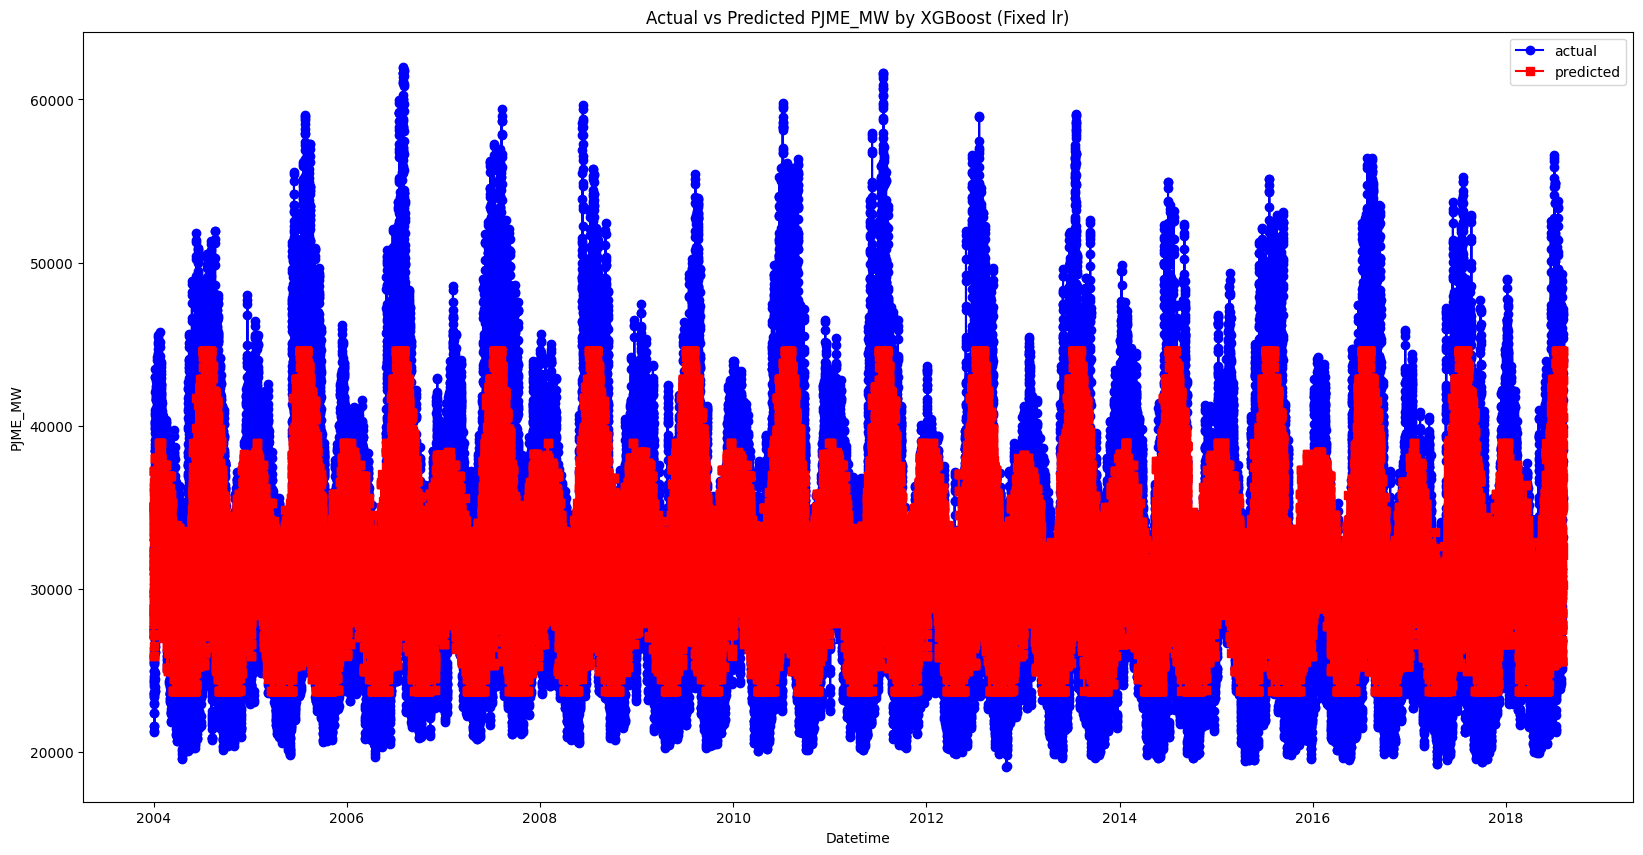

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')

plt.plot(new_df['Datetime'], model.predict(X), label='predicted',color='red', marker='s')

plt.xlabel('Datetime')
plt.ylabel('PJME_MW')

plt.title('Actual vs Predicted PJME_MW by XGBoost (Fixed lr)')

plt.legend()
plt.show()

---------------------------------------------------------------------------------------------------------------

##### SIMULATED ANNEALING LEARNING RATE

In [ ]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']
model = XGBoostRegression()
model.fit(X,Y,min_leaf = 5,min_child_weight = 5,boosting_rounds = 5,
          learning_rate=0.4,split_type="greedy",learning_rate_method="simulated_annealing")

Iteration: 0 RMSE Score = 4888.024971967207
Iteration: 1 RMSE Score = 4246.553125985626
Iteration: 2 RMSE Score = 3972.628066917404
Iteration: 3 RMSE Score = 3842.094032237187
Iteration: 4 RMSE Score = 3747.6063411434448


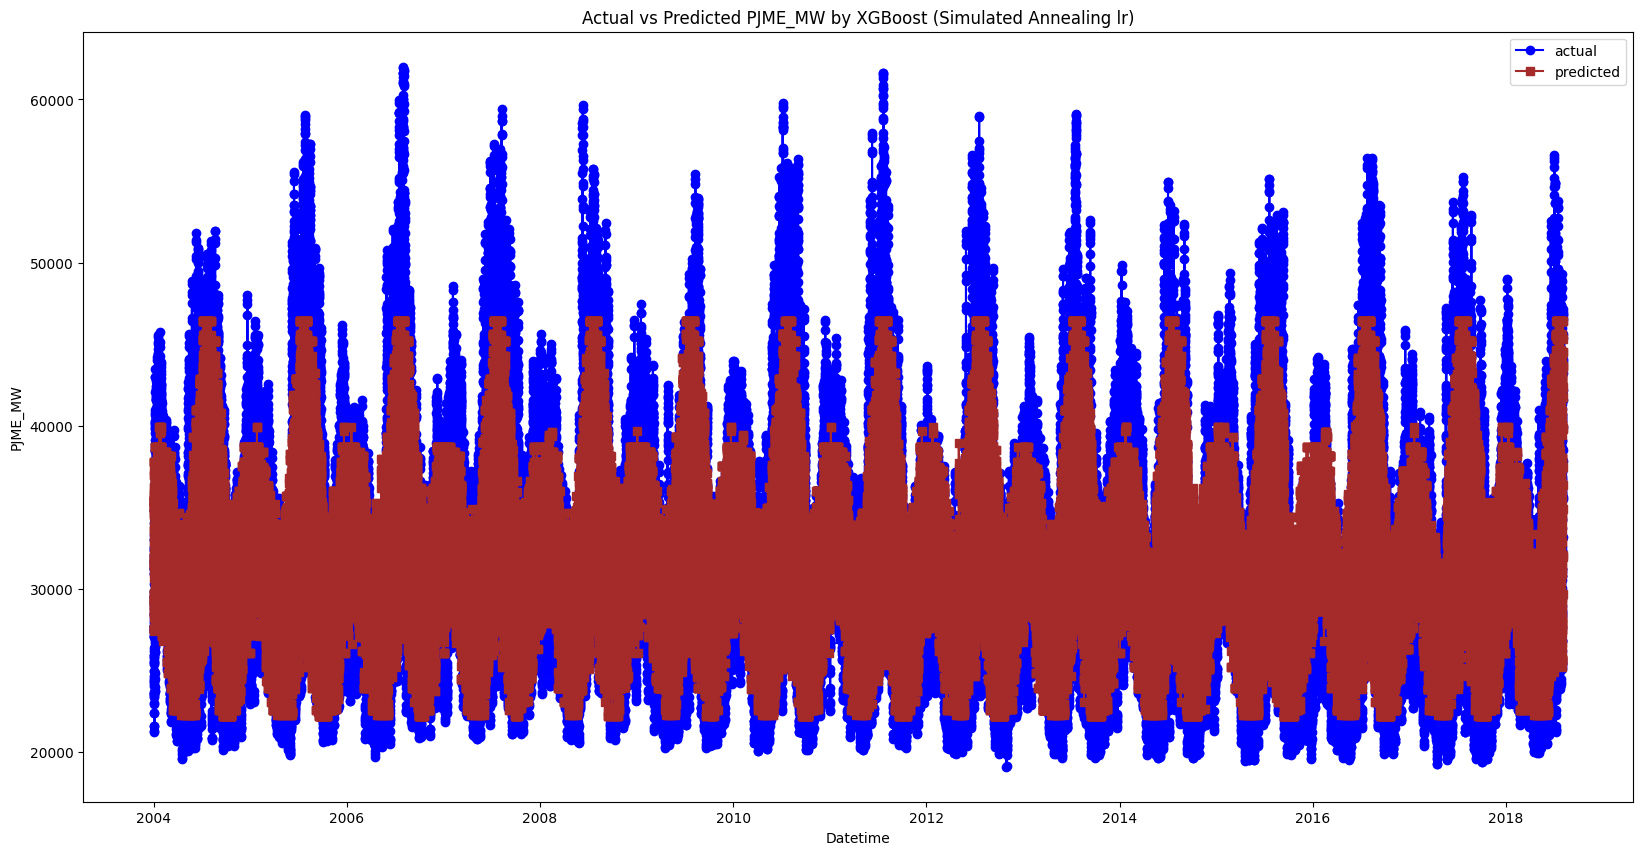

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')

plt.plot(new_df['Datetime'], model.predict(X), label='predicted',color='brown', marker='s')

plt.xlabel('Datetime')
plt.ylabel('PJME_MW')

plt.title('Actual vs Predicted PJME_MW by XGBoost (Simulated Annealing lr)')

plt.legend()
plt.show()

---------------------------------------------------------------------------------------------------------------

##### ADAM OPTIMIZER LEARNING RATE

In [5]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']
model = XGBoostRegression()
model.fit(X,Y,min_leaf = 5,min_child_weight = 5,boosting_rounds = 5,
          learning_rate=0.4,split_type="greedy",learning_rate_method="adam")

Iteration: 0 RMSE Score = 4124.297620510091
Iteration: 1 RMSE Score = 3990.5102490982927
Iteration: 2 RMSE Score = 3881.825804036218
Iteration: 3 RMSE Score = 3793.2408607725415
Iteration: 4 RMSE Score = 3745.790358349496


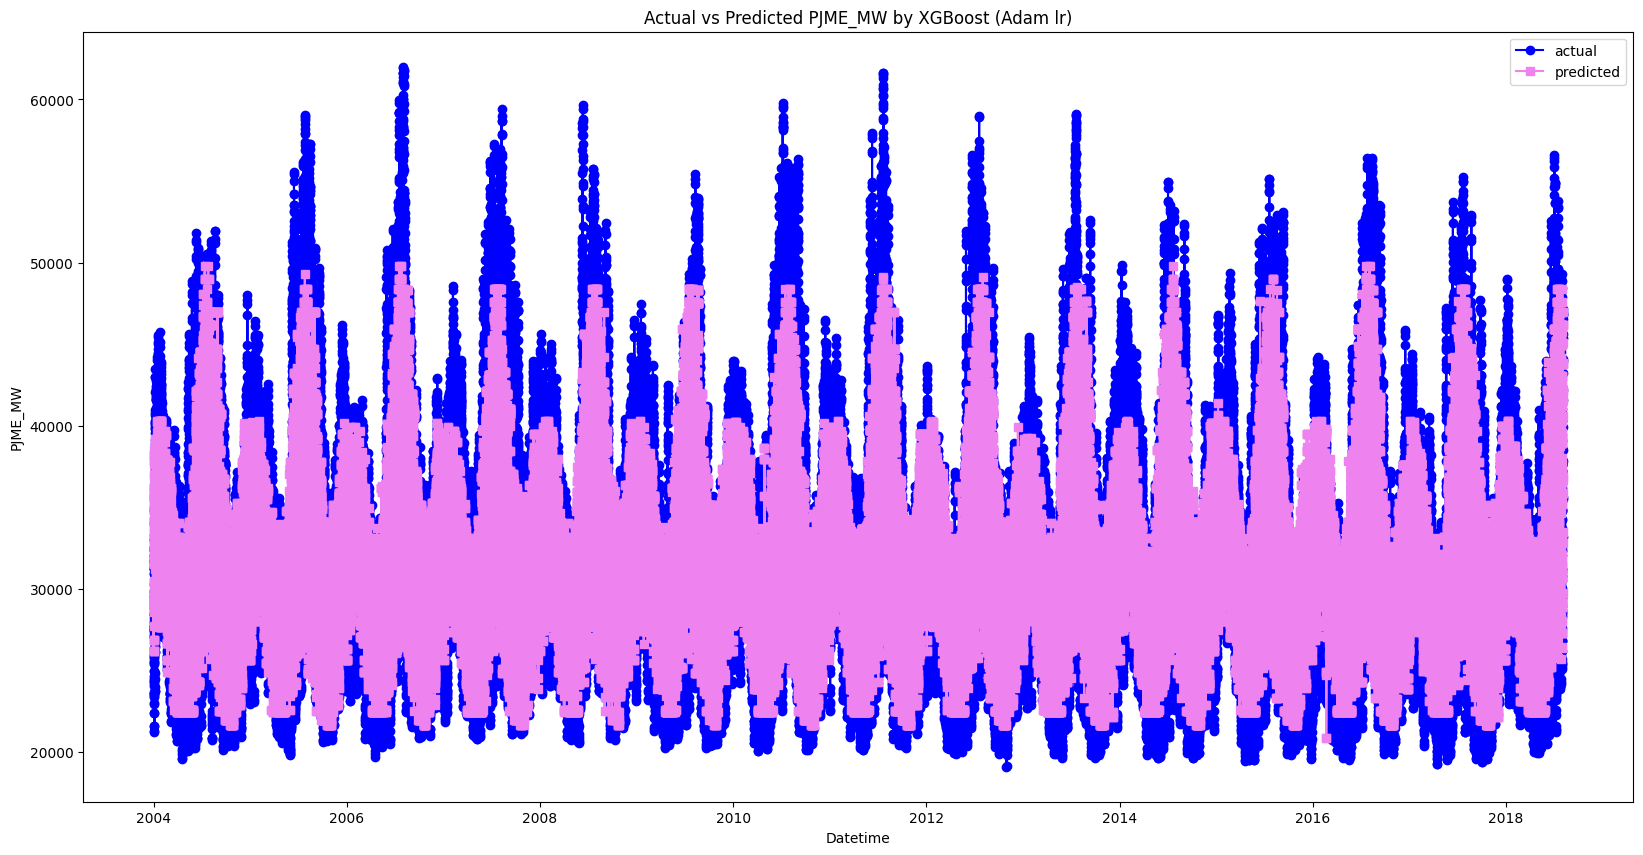

In [6]:
plt.figure(figsize=(20,10))
plt.plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')

plt.plot(new_df['Datetime'], model.predict(X), label='predicted',color='violet', marker='s')

plt.xlabel('Datetime')
plt.ylabel('PJME_MW')

plt.title('Actual vs Predicted PJME_MW by XGBoost (Adam lr)')

plt.legend()
plt.show()

---------------------------------------------------------------------------------------------------------------

##### LIBRARY RESULTS

In [ ]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']
model = xgb.XGBRegressor(booster='gbtree',eta = 0.4, gamma = 1, min_child_weight = 5, max_depth = 5,reg_lambda = 1,
                        objective = "reg:squarederror", n_estimators=5)
model.fit(X, Y, eval_set = [(X,Y)], verbose=True)

[0]	validation_0-rmse:5098.67718
[1]	validation_0-rmse:4448.43722
[2]	validation_0-rmse:4146.15993
[3]	validation_0-rmse:3973.99974
[4]	validation_0-rmse:3861.52802


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.4, eval_metric=None,
             feature_types=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5,
             n_jobs=None, num_parallel_tree=None, ...)

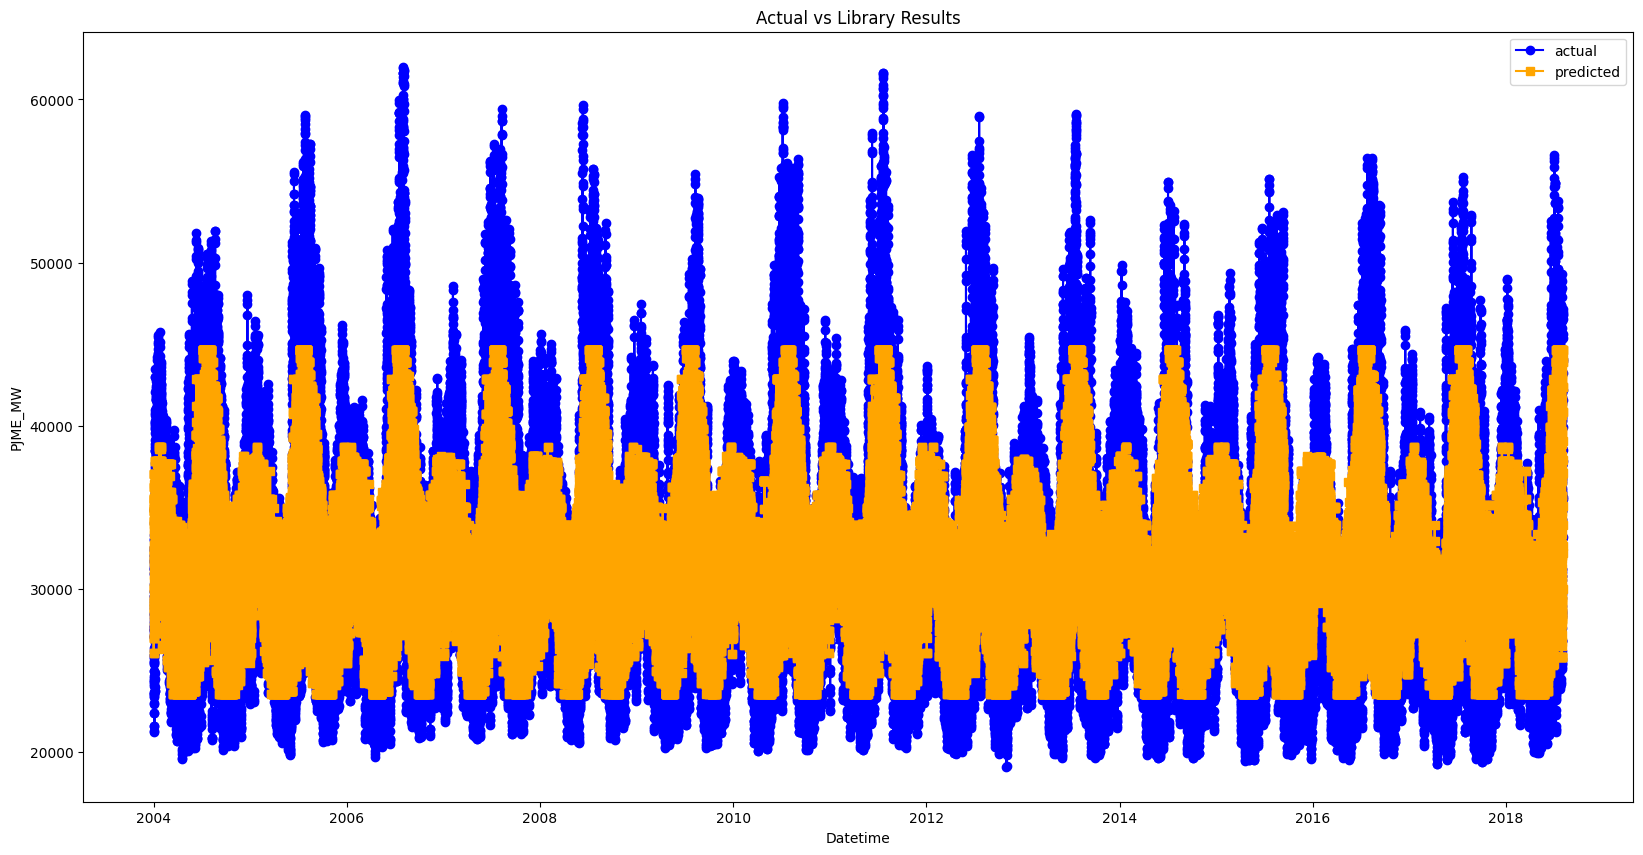

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')

plt.plot(new_df['Datetime'], model.predict(X), label='predicted',color='orange', marker='s')

plt.xlabel('Datetime')
plt.ylabel('PJME_MW')

plt.title('Actual vs Library Results')

plt.legend()
plt.show()

---------------------------------------------------------------------------------------------------------------

##### TRAINING ON SMALLER DATASET

------------------------------------------------------------------------------------------------------------

##### USING GREEDY

In [33]:
def Fit_Model_SD(learning_rate_method):
    with open('dataframe.pickle', 'rb') as f:
        new_df = pickle.load(f)
    new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2012-01')]
    X = new_df.drop(columns=['PJME_MW','Datetime'])
    Y = new_df['PJME_MW']
    
    model = XGBoostRegression()
    model.fit(X,Y,min_leaf = 5,min_child_weight = 5,boosting_rounds = 20,
            learning_rate=0.4,split_type="greedy",learning_rate_method=learning_rate_method,verbose=True)
    return model

In [ ]:
model_fixed = Fit_Model_SD("fixed")
print("Fixed Done!")
model_SA = Fit_Model_SD("simulated_annealing")
print("Simulated Done!")
model_Adam = Fit_Model_SD("adam")
print("Adam Done!")

In [ ]:
Rmse_Fixed = model_fixed.rmse
Rmse_SA = model_SA.rmse
Rmse_Adam = model_Adam.rmse

In [ ]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2012-01')]
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']

model_Lib = xgb.XGBRegressor(booster='gbtree', eta=0.4, gamma=1, min_child_weight=5, max_depth=5, reg_lambda=1,
                         objective="reg:squarederror", n_estimators=20)
model_Lib.fit(X, Y, eval_set=[(X, Y)], verbose=False)
evals_result = model_Lib.evals_result()
Rmse_Lib = evals_result['validation_0']['rmse']


In [36]:
Rmse_Lib

[5063.356353134389,
 4150.776811176316,
 3693.5585088763437,
 3442.018707876542,
 3273.0050287425574,
 3140.14921690018,
 3051.6543269078943,
 3007.442172415849,
 2967.416074788382,
 2940.335874296427,
 2899.763554543917,
 2866.4923518438864,
 2797.3692994232047,
 2753.8683975780973,
 2717.010493806775,
 2683.2260964207026,
 2668.9174639285297,
 2630.082188753995,
 2603.369404307589,
 2574.9841218243123]

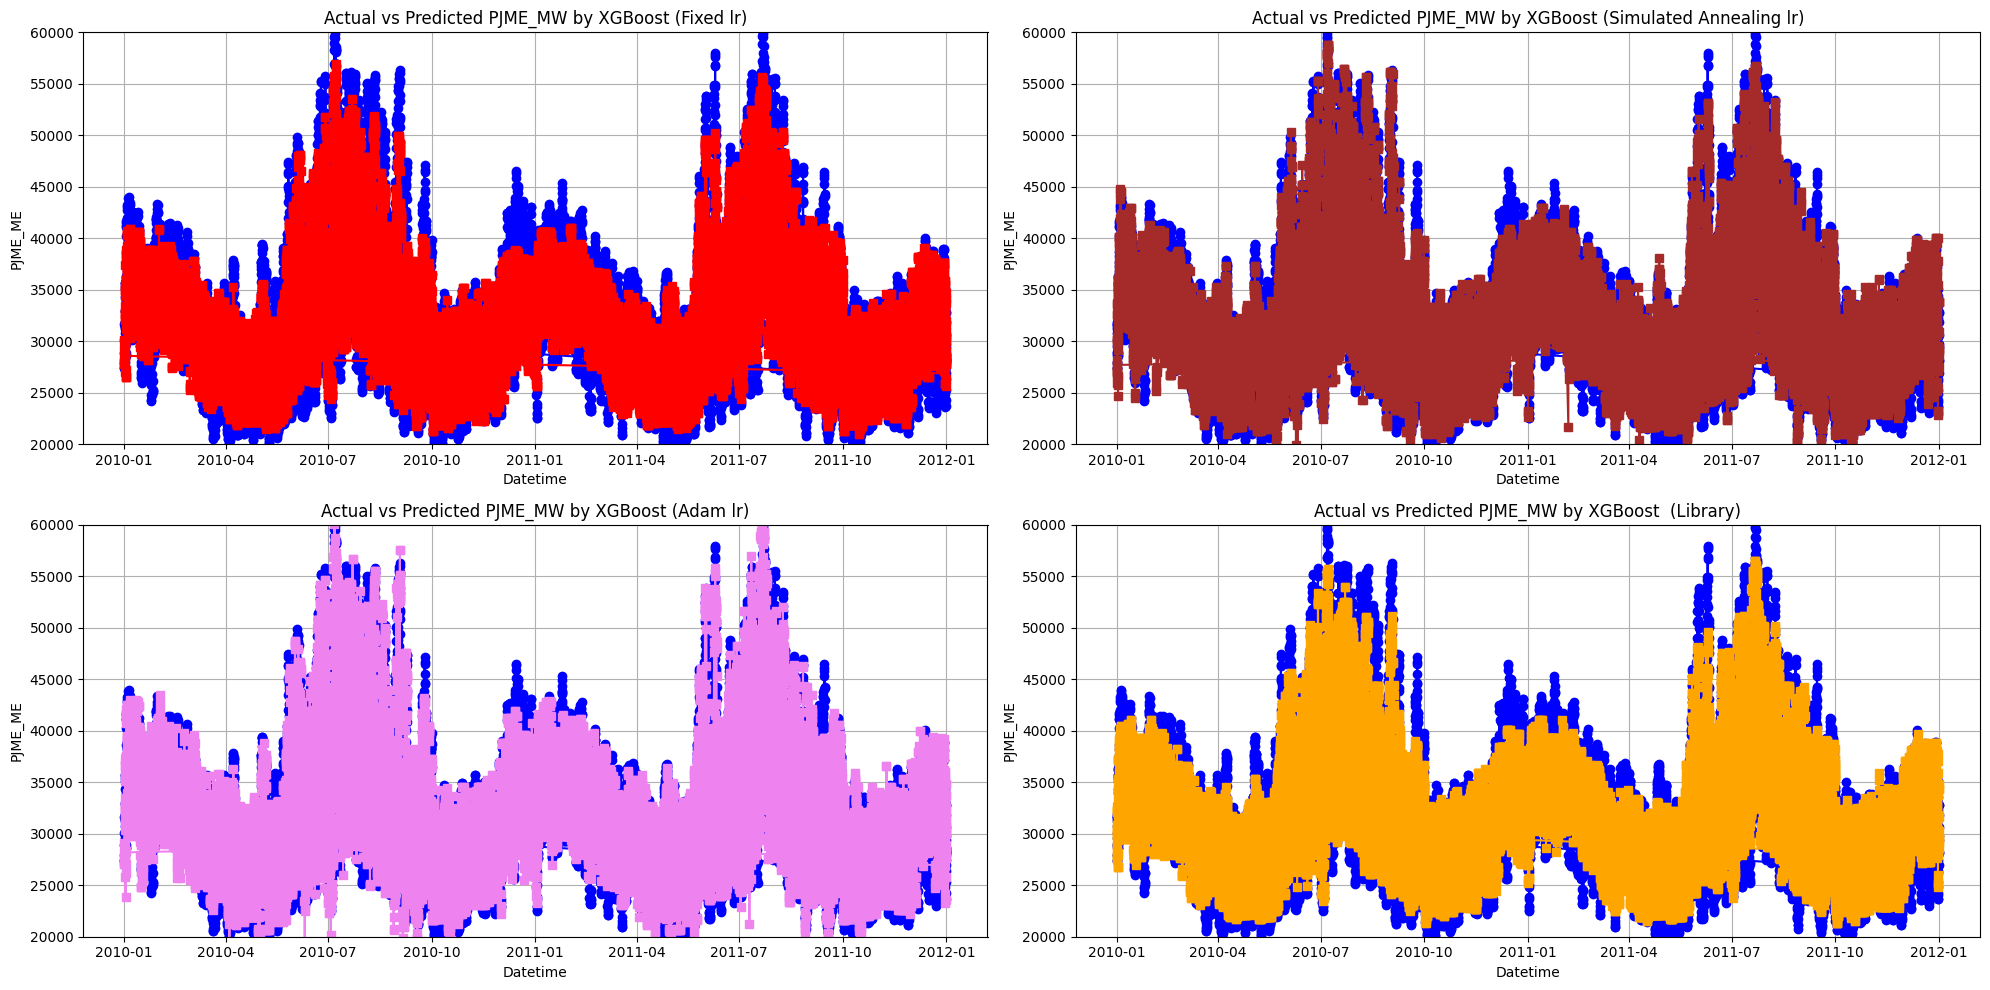

In [17]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2012-01')]
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']


fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 0].plot(new_df['Datetime'], model_fixed.predict(X), label='predicted',color='red', marker='s')
axs[0, 0].set_ylim(20_000, 60_000)
axs[0, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Fixed lr)')
axs[0, 0].set_xlabel('Datetime')
axs[0, 0].set_ylabel('PJME_ME')
axs[0, 0].grid(True)

axs[0, 1].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 1].plot(new_df['Datetime'], model_SA.predict(X), label='predicted',color='brown', marker='s')
axs[0, 1].set_ylim(20_000, 60_000)
axs[0, 1].set_title('Actual vs Predicted PJME_MW by XGBoost (Simulated Annealing lr)')
axs[0, 1].set_xlabel('Datetime')
axs[0, 1].set_ylabel('PJME_ME')
axs[0, 1].grid(True)

axs[1, 0].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 0].plot(new_df['Datetime'], model_Adam.predict(X), label='predicted',color='violet', marker='s')
axs[1, 0].set_ylim(20_000, 60_000)
axs[1, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Adam lr)')
axs[1, 0].set_xlabel('Datetime')
axs[1, 0].set_ylabel('PJME_ME')
axs[1, 0].grid(True)

axs[1, 1].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 1].plot(new_df['Datetime'], model_Lib.predict(X), label='predicted',color='orange', marker='s')
axs[1, 1].set_ylim(20_000, 60_000)
axs[1, 1].set_title('Actual vs Predicted PJME_MW by XGBoost  (Library)')
axs[1, 1].set_xlabel('Datetime')
axs[1, 1].set_ylabel('PJME_ME')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

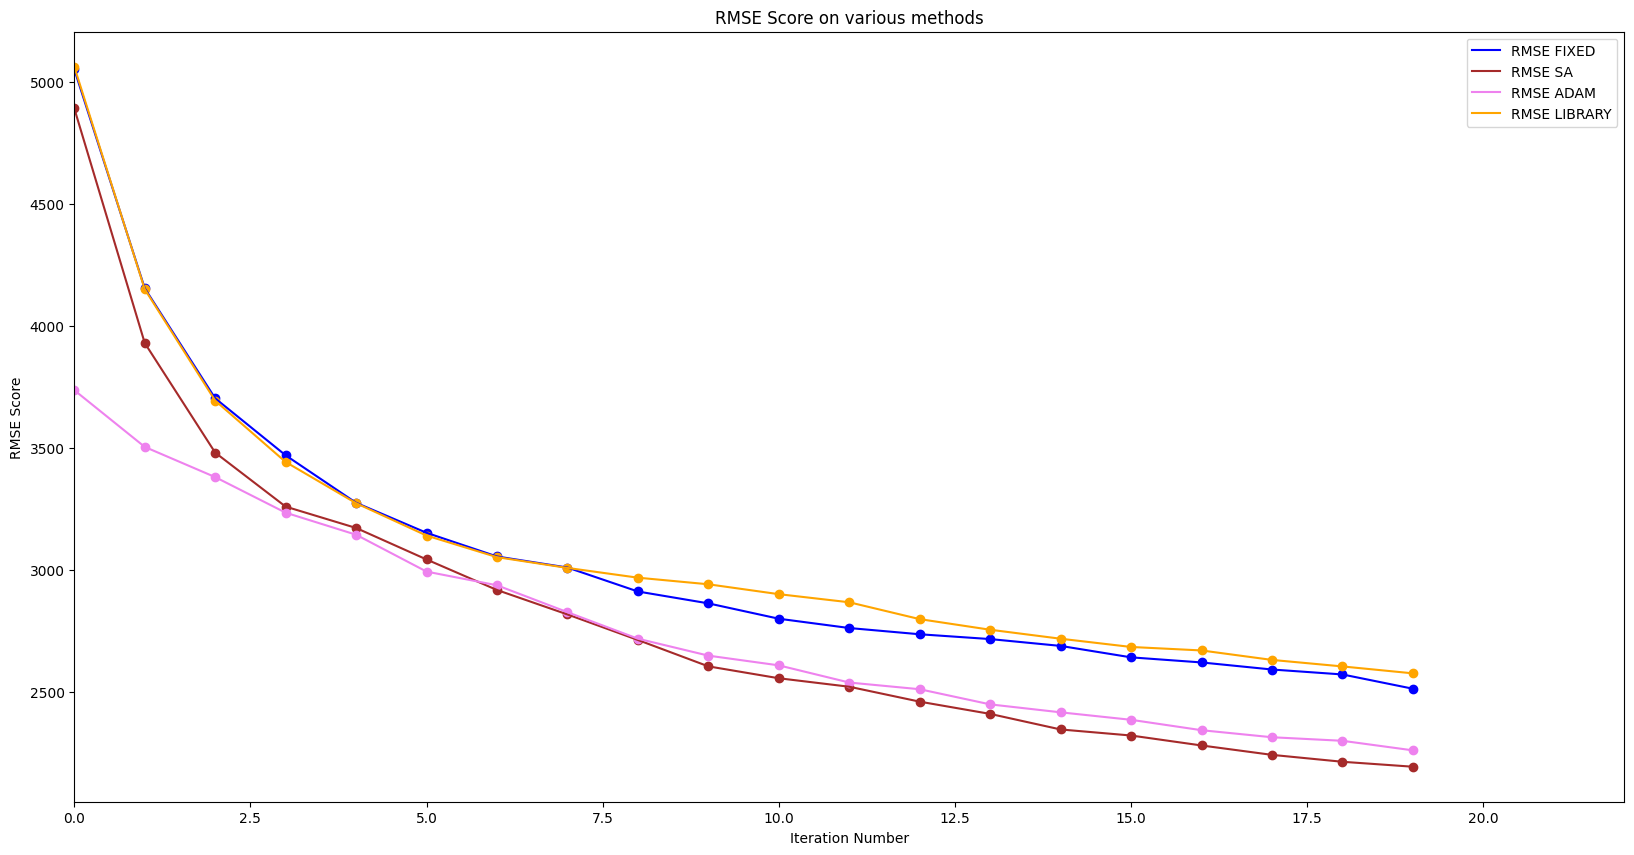

In [18]:
plt.figure(figsize=(20,10))

plt.plot(Rmse_Fixed, label='RMSE FIXED',color='blue')
plt.plot(Rmse_SA, label='RMSE SA',color='brown')
plt.plot(Rmse_Adam, label='RMSE ADAM',color='violet')
plt.plot(Rmse_Lib, label='RMSE LIBRARY',color='orange')
plt.scatter(range(len (Rmse_Fixed)), Rmse_Fixed, color='blue')
plt.scatter(range(len (Rmse_SA)), Rmse_SA, color='brown')
plt.scatter(range(len (Rmse_Adam)), Rmse_Adam, color='violet')
plt.scatter(range(len (Rmse_Lib)), Rmse_Lib, color='orange')

plt.xlim(0,22)
plt.xlabel('Iteration Number')
plt.ylabel('RMSE Score')

plt.title('RMSE Score on various methods')

plt.legend()
plt.show()

#### TESTING ON NEXT 3 MONTHS

In [ ]:

with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
new_df = new_df [(new_df['Datetime'] >= '2012-01') & (new_df['Datetime'] <= '2012-03')]
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']


fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].scatter(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 0].scatter(new_df['Datetime'], model_fixed.predict(X), label='predicted',color='red', marker='s')
axs[0, 0].set_ylim(20_000, 60_000)
axs[0, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Fixed lr)')
axs[0, 0].set_xlabel('Datetime')
axs[0, 0].set_ylabel('PJME_ME')
axs[0, 0].grid(True)

axs[0, 1].scatter(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 1].scatter(new_df['Datetime'], model_SA.predict(X), label='predicted',color='brown', marker='s')
axs[0, 1].set_ylim(20_000, 60_000)
axs[0, 1].set_title('Actual vs Predicted PJME_MW by XGBoost (Simulated Annealing lr)')
axs[0, 1].set_xlabel('Datetime')
axs[0, 1].set_ylabel('PJME_ME')
axs[0, 1].grid(True)

axs[1, 0].scatter(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 0].scatter(new_df['Datetime'], model_Adam.predict(X), label='predicted',color='violet', marker='s')
axs[1, 0].set_ylim(20_000, 60_000)
axs[1, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Adam lr)')
axs[1, 0].set_xlabel('Datetime')
axs[1, 0].set_ylabel('PJME_ME')
axs[1, 0].grid(True)

axs[1, 1].scatter(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 1].scatter(new_df['Datetime'], model_Lib.predict(X), label='predicted',color='orange', marker='s')
axs[1, 1].set_ylim(20_000, 60_000)
axs[1, 1].set_title('Actual vs Predicted PJME_MW by XGBoost  (Library)')
axs[1, 1].set_xlabel('Datetime')
axs[1, 1].set_ylabel('PJME_ME')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:


Rmse_Fixed = np.sqrt(np.mean((model_fixed.predict(X) - Y)**2))
Rmse_SA = np.sqrt(np.mean((model_SA.predict(X) - Y)**2))
Rmse_Adam = np.sqrt(np.mean((model_Adam.predict(X) - Y)**2))
Rmse_Lib = np.sqrt(np.mean((model_Lib.predict(X) - Y)**2))

print('TESTING RMSE ON FIXED LR '+ str(Rmse_Fixed))
print('TESTING RMSE ON Simulated Annealing LR '+ str(Rmse_SA))
print('TESTING RMSE ON Adam Optimizer LR '+ str(Rmse_Adam))
print('TESTING RMSE ON Library '+ str(Rmse_Lib))


---------------------------------------------------------------------------------------------------------------

##### USING APPROXIMATE ALGORITHM

In [26]:
def Fit_Model_SD_Approx(learning_rate_method):
    with open('dataframe.pickle', 'rb') as f:
        new_df = pickle.load(f)
    new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2012-01')]
    X = new_df.drop(columns=['PJME_MW','Datetime'])
    Y = new_df['PJME_MW']
    
    model = XGBoostRegression()
    model.fit(X,Y,min_leaf = 5,min_child_weight = 5,boosting_rounds = 10,
            learning_rate=0.4,split_type="approximate",learning_rate_method=learning_rate_method,verbose=True)
    return model

In [27]:
model_fixed_approx = Fit_Model_SD_Approx("fixed")
Rmse_Fixed = model_fixed_approx.rmse

Iteration: 0 RMSE Score = 5061.114328918808
Iteration: 1 RMSE Score = 4179.933451456965
Iteration: 2 RMSE Score = 3704.121553554231
Iteration: 3 RMSE Score = 3469.3056765164306
Iteration: 4 RMSE Score = 3278.7089010157515
Iteration: 5 RMSE Score = 3145.8367796554635
Iteration: 6 RMSE Score = 3039.706245019503
Iteration: 7 RMSE Score = 2981.004371612975
Iteration: 8 RMSE Score = 2926.9011195999783
Iteration: 9 RMSE Score = 2882.1682889593912


In [28]:
model_SA_approx = Fit_Model_SD_Approx("simulated_annealing")
Rmse_SA = model_SA_approx.rmse

Iteration: 0 RMSE Score = 4950.290218689387
Iteration: 1 RMSE Score = 3968.651323650366
Iteration: 2 RMSE Score = 3478.187874498912
Iteration: 3 RMSE Score = 3234.6853108224595
Iteration: 4 RMSE Score = 3116.0091191237448
Iteration: 5 RMSE Score = 3063.393304906703
Iteration: 6 RMSE Score = 2972.4559235597944
Iteration: 7 RMSE Score = 2912.55163748215
Iteration: 8 RMSE Score = 2768.5790875418415
Iteration: 9 RMSE Score = 2715.3529811280596


In [29]:
model_Adam_approx = Fit_Model_SD_Approx("adam")
Rmse_Adam = model_Adam_approx.rmse

Iteration: 0 RMSE Score = 3753.675281490776
Iteration: 1 RMSE Score = 3491.688032845927
Iteration: 2 RMSE Score = 3320.8817030384034
Iteration: 3 RMSE Score = 3163.399223269273
Iteration: 4 RMSE Score = 3025.35071225402
Iteration: 5 RMSE Score = 2944.371432930036
Iteration: 6 RMSE Score = 2858.284302633054
Iteration: 7 RMSE Score = 2796.849442463732
Iteration: 8 RMSE Score = 2741.2977704711993
Iteration: 9 RMSE Score = 2706.862948155994


In [30]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2011-01')]
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']

model_Lib = xgb.XGBRegressor(booster='gbtree', eta=0.4, gamma=1, min_child_weight=5, max_depth=5, reg_lambda=1,
                         objective="reg:squarederror", n_estimators=10)
model_Lib.fit(X, Y, eval_set=[(X, Y)], verbose=True)
evals_result = model_Lib.evals_result()
Rmse_Lib = evals_result['validation_0']['rmse']

[0]	validation_0-rmse:5120.60268
[1]	validation_0-rmse:4124.49646
[2]	validation_0-rmse:3561.21071
[3]	validation_0-rmse:3172.49750
[4]	validation_0-rmse:2963.99251
[5]	validation_0-rmse:2806.09338
[6]	validation_0-rmse:2687.94982
[7]	validation_0-rmse:2576.75893
[8]	validation_0-rmse:2438.06890
[9]	validation_0-rmse:2375.62143


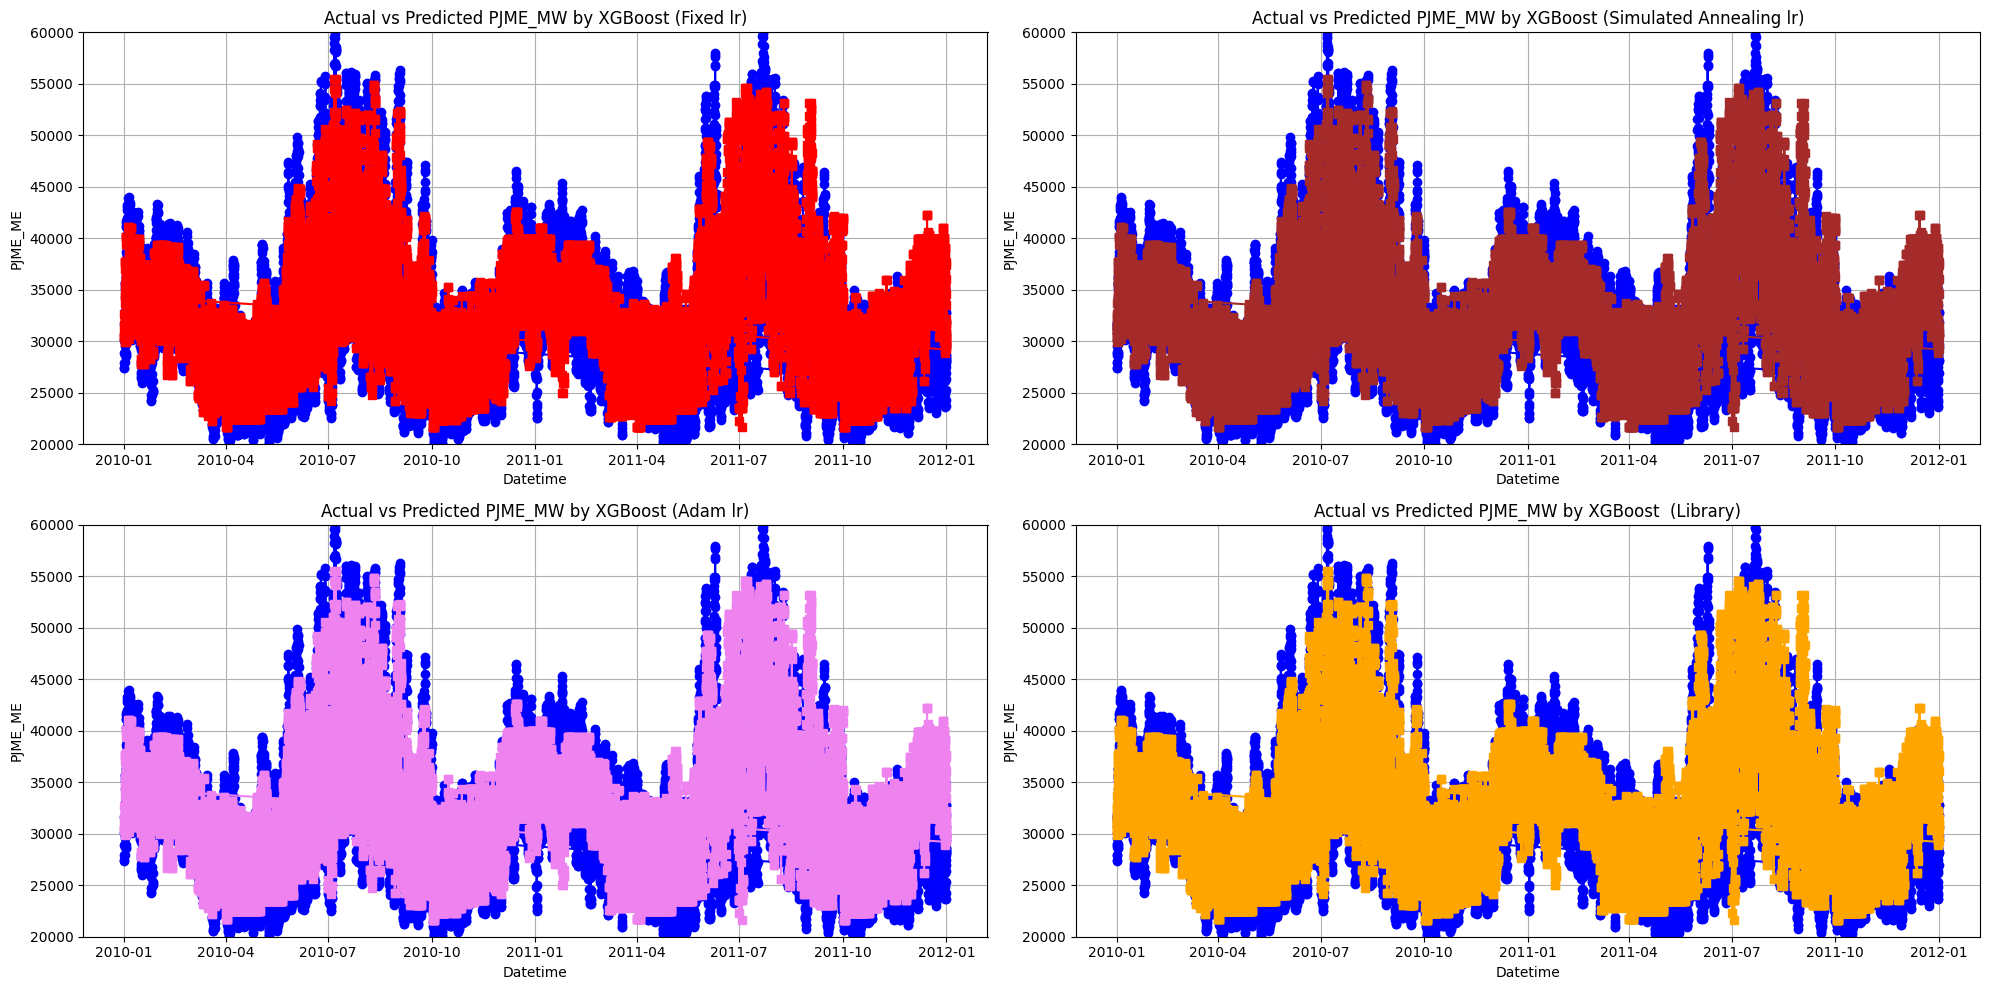

In [11]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2012-01')]
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']


fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 0].plot(new_df['Datetime'], model_fixed_approx.predict(X), label='predicted',color='red', marker='s')
axs[0, 0].set_ylim(20_000, 60_000)
axs[0, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Fixed lr)')
axs[0, 0].set_xlabel('Datetime')
axs[0, 0].set_ylabel('PJME_ME')
axs[0, 0].grid(True)

axs[0, 1].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 1].plot(new_df['Datetime'], model_SA_approx.predict(X), label='predicted',color='brown', marker='s')
axs[0, 1].set_ylim(20_000, 60_000)
axs[0, 1].set_title('Actual vs Predicted PJME_MW by XGBoost (Simulated Annealing lr)')
axs[0, 1].set_xlabel('Datetime')
axs[0, 1].set_ylabel('PJME_ME')
axs[0, 1].grid(True)

axs[1, 0].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 0].plot(new_df['Datetime'], model_Adam_approx.predict(X), label='predicted',color='violet', marker='s')
axs[1, 0].set_ylim(20_000, 60_000)
axs[1, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Adam lr)')
axs[1, 0].set_xlabel('Datetime')
axs[1, 0].set_ylabel('PJME_ME')
axs[1, 0].grid(True)

axs[1, 1].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 1].plot(new_df['Datetime'], model_Lib.predict(X), label='predicted',color='orange', marker='s')
axs[1, 1].set_ylim(20_000, 60_000)
axs[1, 1].set_title('Actual vs Predicted PJME_MW by XGBoost  (Library)')
axs[1, 1].set_xlabel('Datetime')
axs[1, 1].set_ylabel('PJME_ME')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

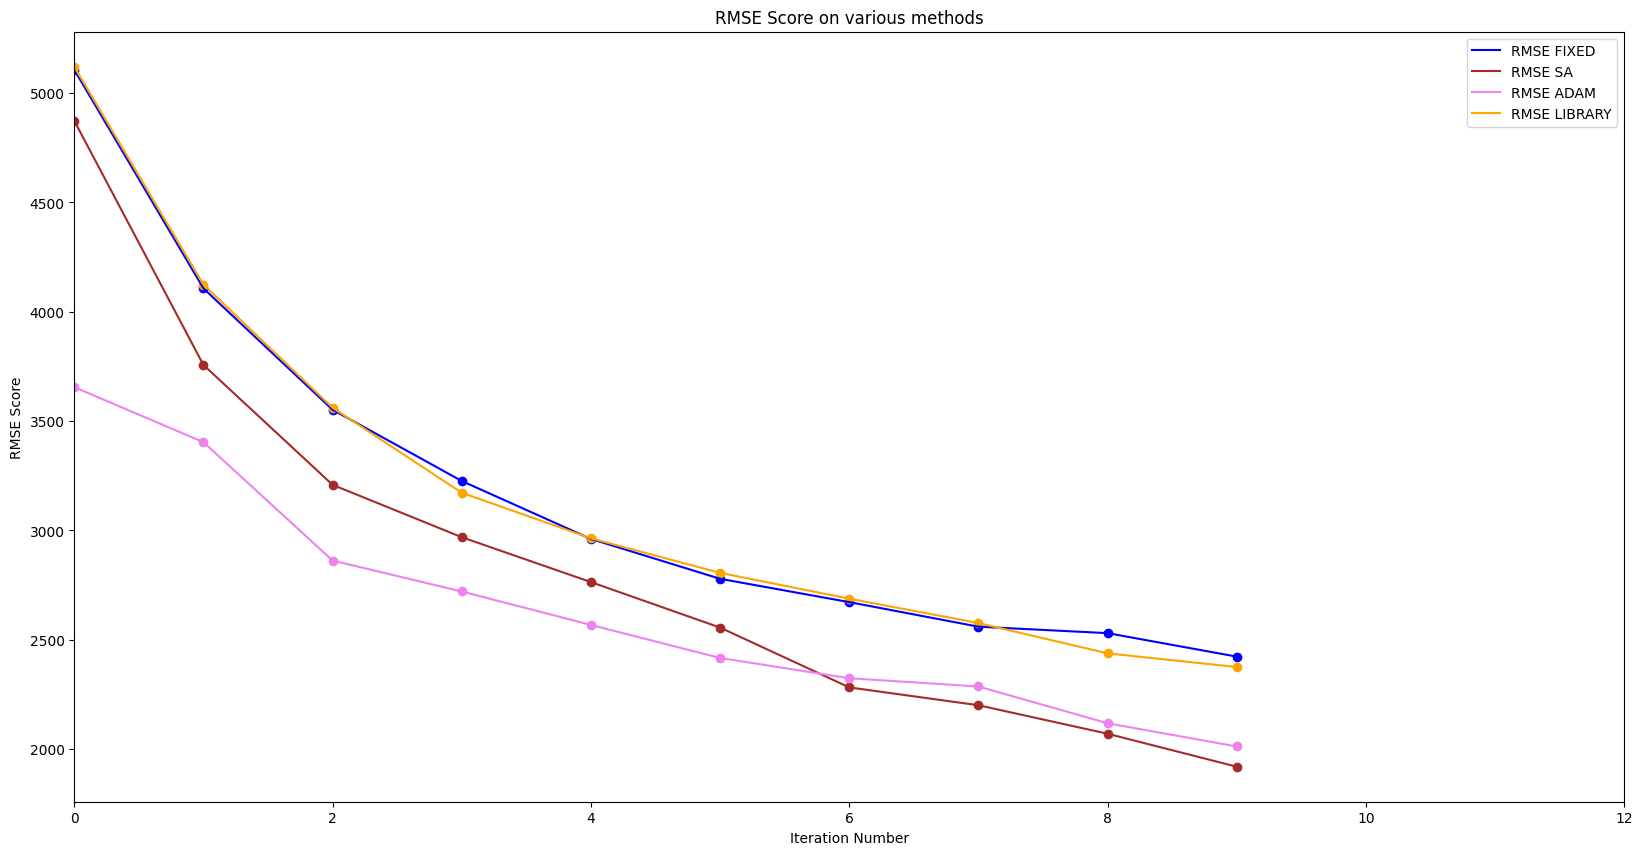

In [23]:
plt.figure(figsize=(20,10))

plt.plot(Rmse_Fixed, label='RMSE FIXED',color='blue')
plt.plot(Rmse_SA, label='RMSE SA',color='brown')
plt.plot(Rmse_Adam, label='RMSE ADAM',color='violet')
plt.plot(Rmse_Lib, label='RMSE LIBRARY',color='orange')
plt.scatter(range(len (Rmse_Fixed)), Rmse_Fixed, color='blue')
plt.scatter(range(len (Rmse_SA)), Rmse_SA, color='brown')
plt.scatter(range(len (Rmse_Adam)), Rmse_Adam, color='violet')
plt.scatter(range(len (Rmse_Lib)), Rmse_Lib, color='orange')

plt.xlim(0,12)
plt.xlabel('Iteration Number')
plt.ylabel('RMSE Score')

plt.title('RMSE Score on various methods')

plt.legend()
plt.show()

#### TESTING ON NEXT 3 MONTHS

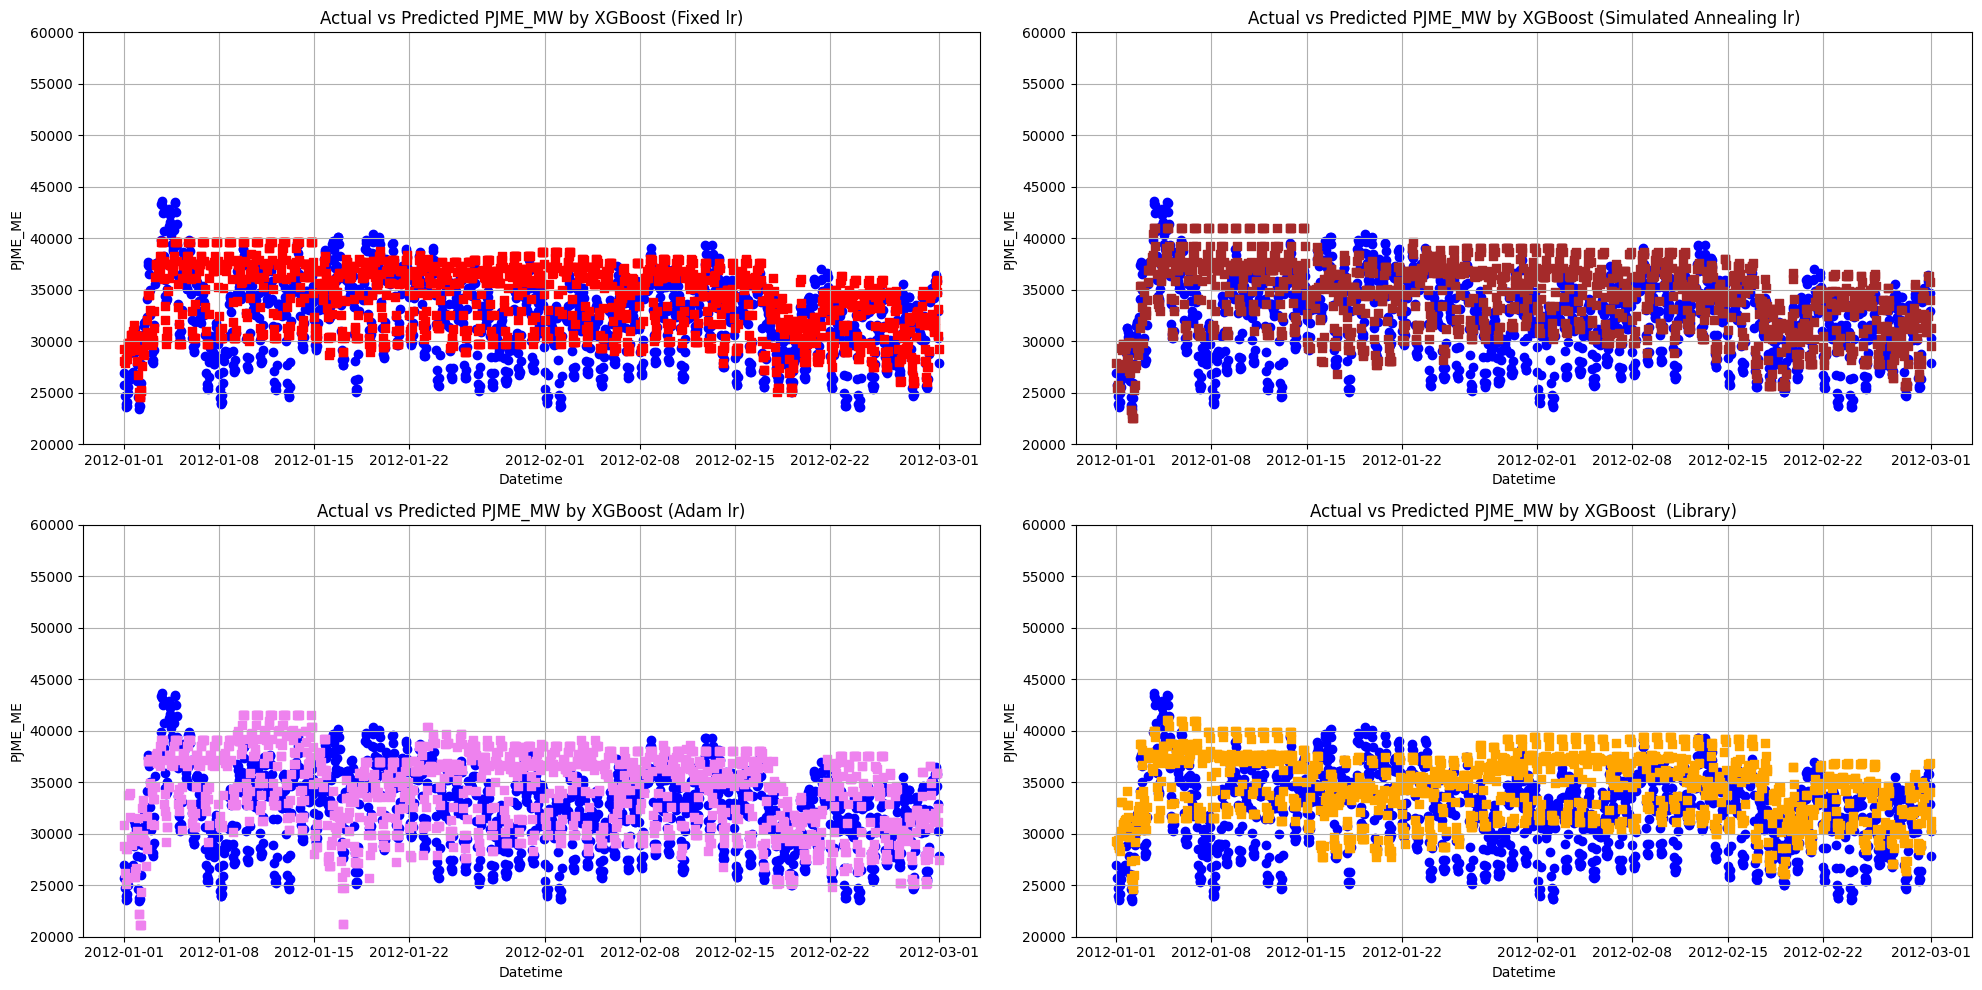

In [31]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
new_df = new_df [(new_df['Datetime'] >= '2012-01') & (new_df['Datetime'] <= '2012-03')]
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']


fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].scatter(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 0].scatter(new_df['Datetime'], model_fixed_approx.predict(X), label='predicted',color='red', marker='s')
axs[0, 0].set_ylim(20_000, 60_000)
axs[0, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Fixed lr)')
axs[0, 0].set_xlabel('Datetime')
axs[0, 0].set_ylabel('PJME_ME')
axs[0, 0].grid(True)

axs[0, 1].scatter(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 1].scatter(new_df['Datetime'], model_SA_approx.predict(X), label='predicted',color='brown', marker='s')
axs[0, 1].set_ylim(20_000, 60_000)
axs[0, 1].set_title('Actual vs Predicted PJME_MW by XGBoost (Simulated Annealing lr)')
axs[0, 1].set_xlabel('Datetime')
axs[0, 1].set_ylabel('PJME_ME')
axs[0, 1].grid(True)

axs[1, 0].scatter(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 0].scatter(new_df['Datetime'], model_Adam_approx.predict(X), label='predicted',color='violet', marker='s')
axs[1, 0].set_ylim(20_000, 60_000)
axs[1, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Adam lr)')
axs[1, 0].set_xlabel('Datetime')
axs[1, 0].set_ylabel('PJME_ME')
axs[1, 0].grid(True)

axs[1, 1].scatter(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 1].scatter(new_df['Datetime'], model_Lib.predict(X), label='predicted',color='orange', marker='s')
axs[1, 1].set_ylim(20_000, 60_000)
axs[1, 1].set_title('Actual vs Predicted PJME_MW by XGBoost  (Library)')
axs[1, 1].set_xlabel('Datetime')
axs[1, 1].set_ylabel('PJME_ME')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [32]:
Rmse_Fixed = np.sqrt(np.mean((model_fixed_approx.predict(X) - Y)**2))
Rmse_SA = np.sqrt(np.mean((model_SA_approx.predict(X) - Y)**2))
Rmse_Adam = np.sqrt(np.mean((model_Adam_approx.predict(X) - Y)**2))
Rmse_Lib = np.sqrt(np.mean((model_Lib.predict(X) - Y)**2))

print('TESTING RMSE ON FIXED LR '+ str(Rmse_Fixed))
print('TESTING RMSE ON Simulated Annealing LR '+ str(Rmse_SA))
print('TESTING RMSE ON Adam Optimizer LR '+ str(Rmse_Adam))
print('TESTING RMSE ON Library '+ str(Rmse_Lib))


TESTING RMSE ON FIXED LR 3244.2826756186287
TESTING RMSE ON Simulated Annealing LR 3474.596628480607
TESTING RMSE ON Adam Optimizer LR 3701.7522655877174
TESTING RMSE ON Library 3658.367692319738


---------------------------------------------------------------------------------------------------------------

# GRID SEARCH 

In [24]:
def hyperparameter_tuning(X, y, depth, min_leaf, learning_rate, boosting_rounds, min_child_weight):

    # Define the parameter grid
    param_grid = {
        'depth': depth,
        'min_leaf': min_leaf,
        'learning_rate': learning_rate,
        'boosting_rounds': boosting_rounds,
        'min_child_weight': min_child_weight
    }

    model = XGBoostRegression()
    old_rmse=1e8
    params=[]

    for depth in param_grid['depth']:
        for min_leaf in param_grid['min_leaf']:
                for learning_rate in param_grid['learning_rate']:
                    for boosting_rounds in param_grid['boosting_rounds']:
                        for min_child_weight in param_grid['min_child_weight']:
                            model.fit(X,y , depth=depth, min_leaf=min_leaf, learning_rate=learning_rate, boosting_rounds=boosting_rounds, min_child_weight=min_child_weight, verbose=False)
                            predictions = model.predict(X)
                            Actual_Values = np.array(y)
                            rmse = np.sqrt(np.mean((predictions - Actual_Values)**2))
                            if rmse<old_rmse:
                                    old_rmse=rmse     
                                    params=[depth,min_leaf,learning_rate,boosting_rounds,min_child_weight]


    print("RMSE: " + str(old_rmse))
    print(params)
    return params

Dataset Size: 13622


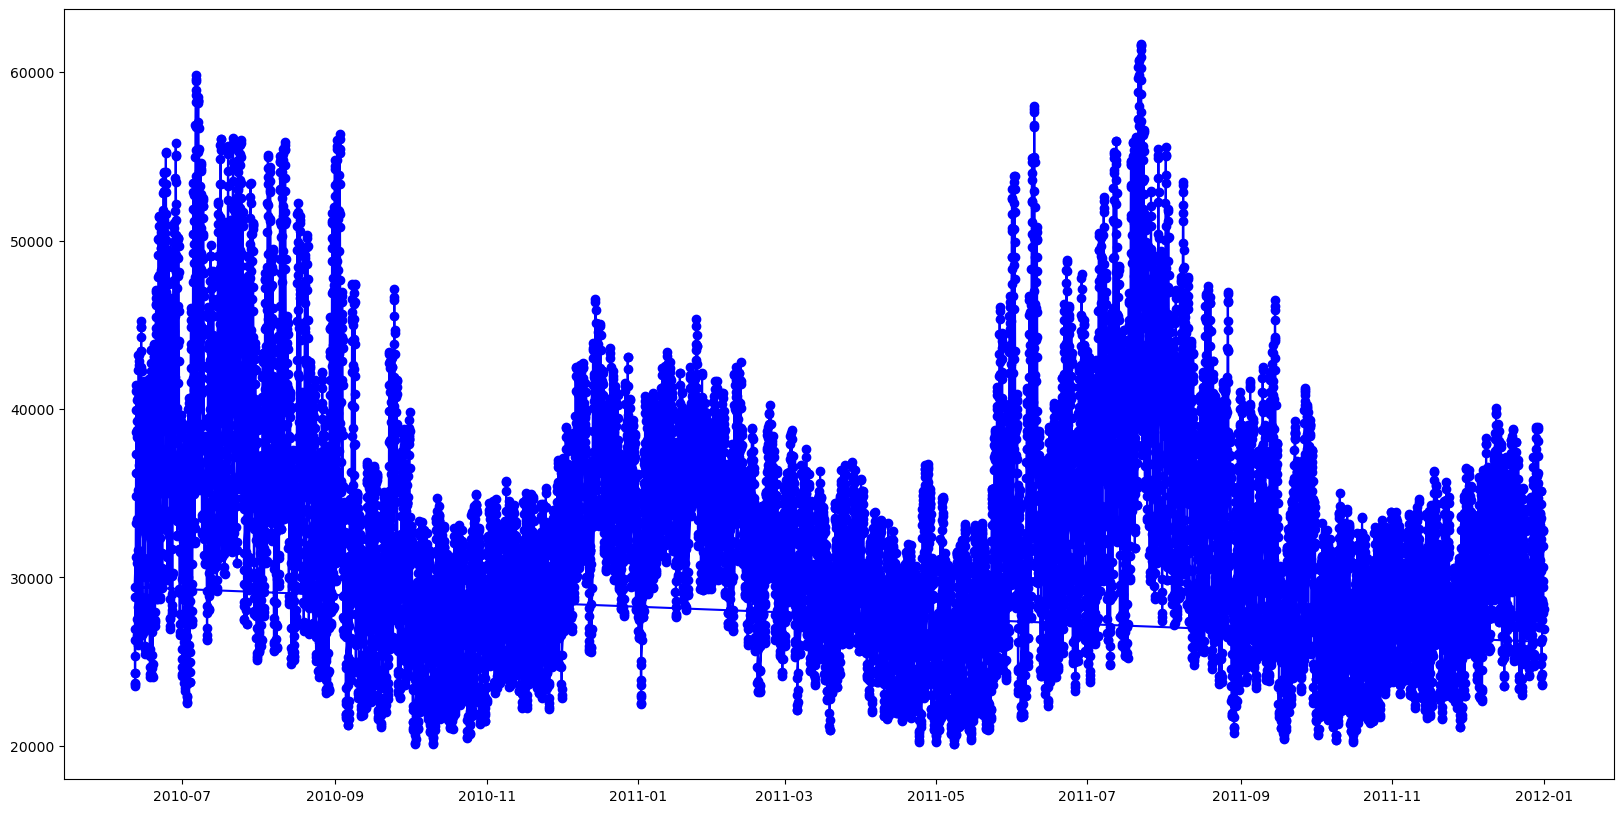

In [ ]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)

new_df = new_df [(new_df['Datetime'] >= '2010-06-12') & (new_df['Datetime'] <= '2012-01-01')]
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']
print("Dataset Size: " + str(len(Y)))
plt.figure(figsize=(20,10))
plt.plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')

In [ ]:
parameters = hyperparameter_tuning(X,Y,[2, 4, 6], [3,5,8], [0.1, 0.4, 0.7], [20], [3,5,8])

[2, 5, 0.4, 20, 5]


-------------------------------------------------------------------------------------------

# K-FOLD CROSS VALIDATION

Dataset Size: 8754


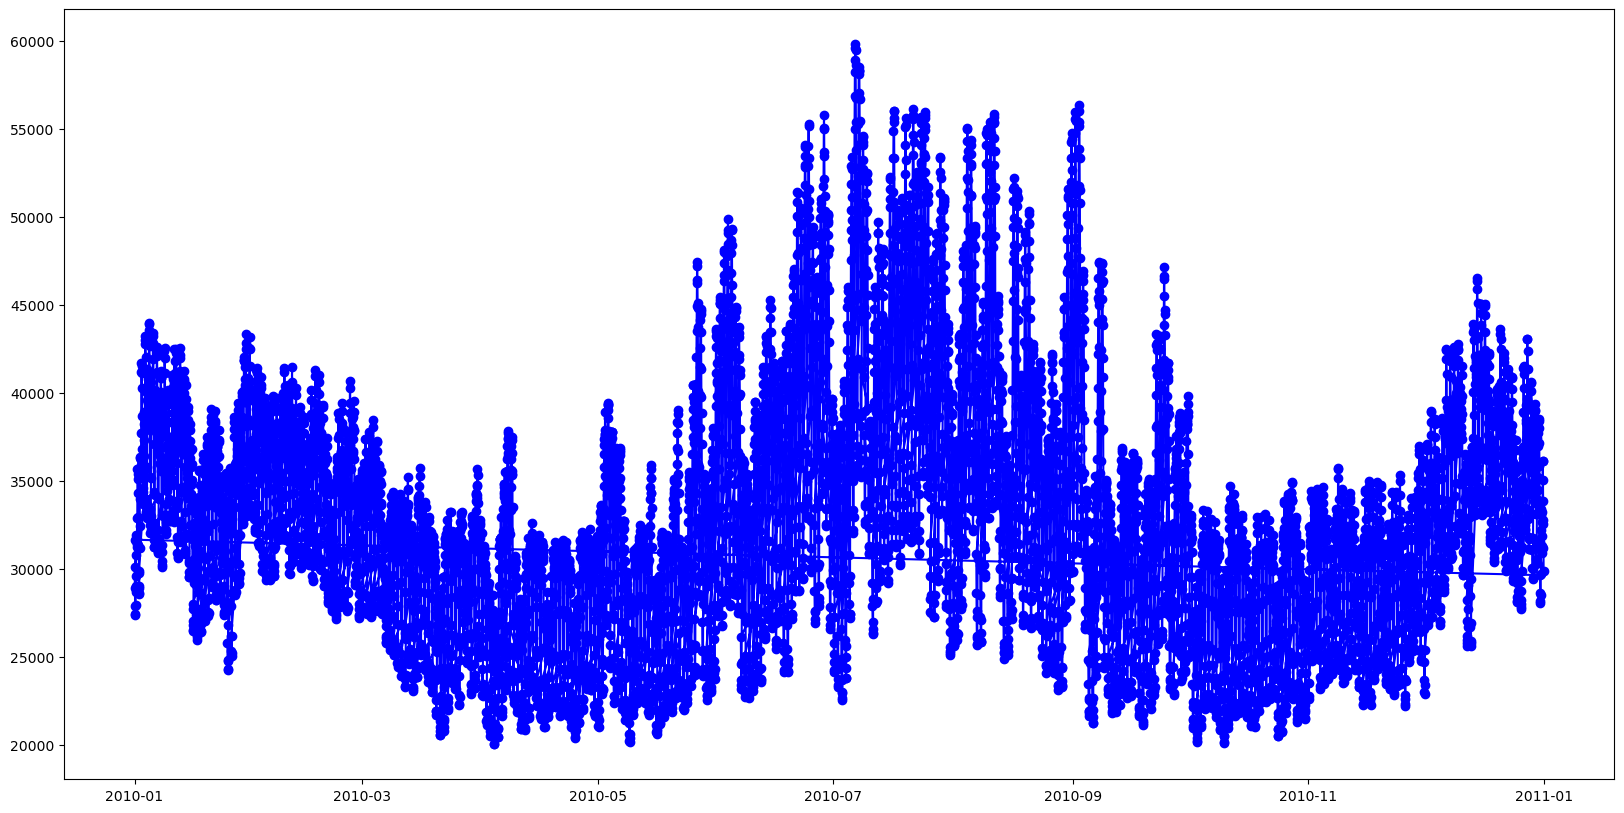

In [ ]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)

new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2011-01')]
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']
print("Dataset Size: " + str(len(Y)))
plt.figure(figsize=(20,10))
plt.plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')

In [1]:
def Fit_Model_SD_Kfold(learning_rate_method):
    
    with open('dataframe.pickle', 'rb') as f:
        new_df = pickle.load(f)
    
    new_df = new_df [(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2011-01')]
    new_df.reset_index(inplace=True, drop=True)
    X = new_df.drop(columns=['PJME_MW','Datetime'])
    Y = new_df['PJME_MW']
    
    model = XGBoostRegression()
    
    model.fit(X,Y,
              depth=parameters[0],
              min_leaf = parameters[1],
              min_child_weight = parameters[4],
              boosting_rounds = parameters[3],
              learning_rate=parameters[2],
              split_type="greedy",
              learning_rate_method=learning_rate_method,
              verbose=False, 
              k_fold_cross_validation=True)
    return model

In [ ]:
model_fixed = Fit_Model_SD_Kfold("fixed")
print("Fixed Done!")
model_SA = Fit_Model_SD_Kfold("simulated_annealing")
print("Simulated Done!")
model_Adam = Fit_Model_SD_Kfold("adam")
print("Adam Done!")

Fixed Done!
Simulated Done!
Adam Done!


In [ ]:
Rmse_Fixed = model_fixed.rmse
Rmse_SA = model_SA.rmse
Rmse_Adam = model_Adam.rmse


Rmse_Fixed_Kcross = model_fixed.rmse_kfold
Rmse_SA_Kcross = model_SA.rmse_kfold
Rmse_Adam_Kcross = model_Adam.rmse_kfold

In [ ]:
print("Training RMSE Simulated Annealing: " + str(Rmse_SA))
print("Training RMSE Fixed Learning Rate: " + str(Rmse_Fixed))
print("Training RMSE Adam: " + str(Rmse_Adam))

Training RMSE Simulated Annealing: [3030.796501395469, 2353.5361024354625, 2022.5174264491638, 1703.3166551733295, 1473.7854667856695, 1598.467725948483, 1909.2007776962357, 2197.4466709013013, 2065.108826340738, 1903.942576873715, 2120.0400852305725, 2169.91521791018, 2106.50890647162, 2178.0626517962783, 2120.5473210528185, 2020.2223752668747, 1940.3681542133245, 1916.2156498651198, 1978.2827260548936, 1922.4849056136848]
Training RMSE Fixed Learning Rate: [3191.973291992219, 2658.567359434264, 2504.2654457201197, 2121.368407810654, 1854.2531574495883, 1943.605177813881, 2302.397119098799, 2397.314147005342, 2426.515369831039, 2372.241995152879, 2657.8962393969355, 2707.1535753910794, 2738.558451655784, 2610.931183194809, 2553.1459803904445, 2409.6586950195715, 2297.4377937286345, 2249.1754944041563, 2195.1767218799746, 2149.41220776237]
Training RMSE Adam: [2523.4156753478205, 2016.959691310834, 2829.554831657043, 3203.107636782196, 3347.8955454313027, 2256.154048590213, 2324.691282

In [ ]:
print("Testing RMSE Simulated Annealing: " + str(Rmse_SA_Kcross))
print("Testing RMSE Fixed Learning Rate: " + str(Rmse_Fixed_Kcross))
print("Testing RMSE Adam: " + str(Rmse_Adam_Kcross))

Testing RMSE Simulated Annealing: [4305.456574624333, 4466.825205455693, 2932.966779125158, 2642.1337663118934, 4356.752008509175, 5918.591666429908, 10094.79010441142, 5913.410551834198, 4310.767031828116, 6467.9512264976165, 7011.2345600109775, 7042.93617734629, 7821.511966819314, 4987.288500815544, 3332.9979833448074, 2363.156107396427, 5024.968981640825, 7300.66386716685, 7035.111341981701, 5662.675563429064]
Testing RMSE Fixed Learning Rate: [4293.823424795854, 4771.518155578707, 3432.937135662878, 2826.2148162428502, 4111.664055838439, 5628.305959587003, 6138.366874803564, 5524.1484786622195, 4602.70016083998, 6819.848630735637, 6247.086592003222, 6036.720869438535, 4280.759414128048, 5325.878772037485, 3621.7855519963528, 2786.837033632903, 3735.5262994103296, 4146.522811955907, 3864.4048931939587, 3861.3903931446757]
Testing RMSE Adam: [4466.40563611666, 4081.5923299480023, 3933.760419341809, 4569.0257342336345, 4087.9727497502518, 5356.632299720735, 6797.330892006348, 6002.978

In [ ]:
# Load DataFrame
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)

# Filter data for the desired time period
new_df = new_df[(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2011-01')]

# Separate features (X) and target (Y)
X = new_df.drop(columns=['PJME_MW', 'Datetime'])
Y = new_df['PJME_MW']

# Define XGBoost model
model_Lib = xgb.XGBRegressor(booster='gbtree', eta=0.4, gamma=1, min_child_weight=5, max_depth=5, reg_lambda=1,
                              objective="reg:squarederror", n_estimators=20)

# Define number of folds for k-fold cross-validation
k_folds = parameters[3]

# Define k-fold cross-validation
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize arrays to store training and testing RMSE for all iterations
Rmse_Lib_Training = []
Rmse_Lib_Testing = []

# Perform k-fold cross-validation
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    model_Lib.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
    evals_result = model_Lib.evals_result()
    
    Rmse_Lib_Training.append(np.mean(np.array(evals_result['validation_0']['rmse'])))
    Rmse_Lib_Testing.append(np.mean(np.array(evals_result['validation_1']['rmse'])))

# Convert lists of arrays to numpy arrays
Rmse_Lib_Training = np.array(Rmse_Lib_Training)
Rmse_Lib_Testing = np.array(Rmse_Lib_Testing)

# Print the arrays of training and testing RMSE for all iterations
print("Training RMSE for all iterations:", Rmse_Lib_Training)
print("Testing RMSE for all iterations:", Rmse_Lib_Testing)


Training RMSE for all iterations: [2687.12734091 2638.0881182  2598.49844687 2647.47588603 2658.43529799
 2630.00120689 2663.8505327  2658.90425051 2600.37002088 2631.26196193
 2592.86030937 2674.21206737 2659.38501792 2661.99894975 2584.67846074
 2696.62058959 2632.84153764 2685.15973506 2719.00341985 2642.46722267]
Testing RMSE for all iterations: [2718.85426082 2745.00988623 2650.29049159 2840.49283238 2808.6830449
 2712.70124341 3059.80096797 2699.68600142 2694.67054258 2678.49873523
 2777.78620824 2777.82819184 2698.79841231 2892.28871198 2684.3757784
 2884.12442916 2866.96752715 2947.67785378 2882.88264447 2841.95704071]


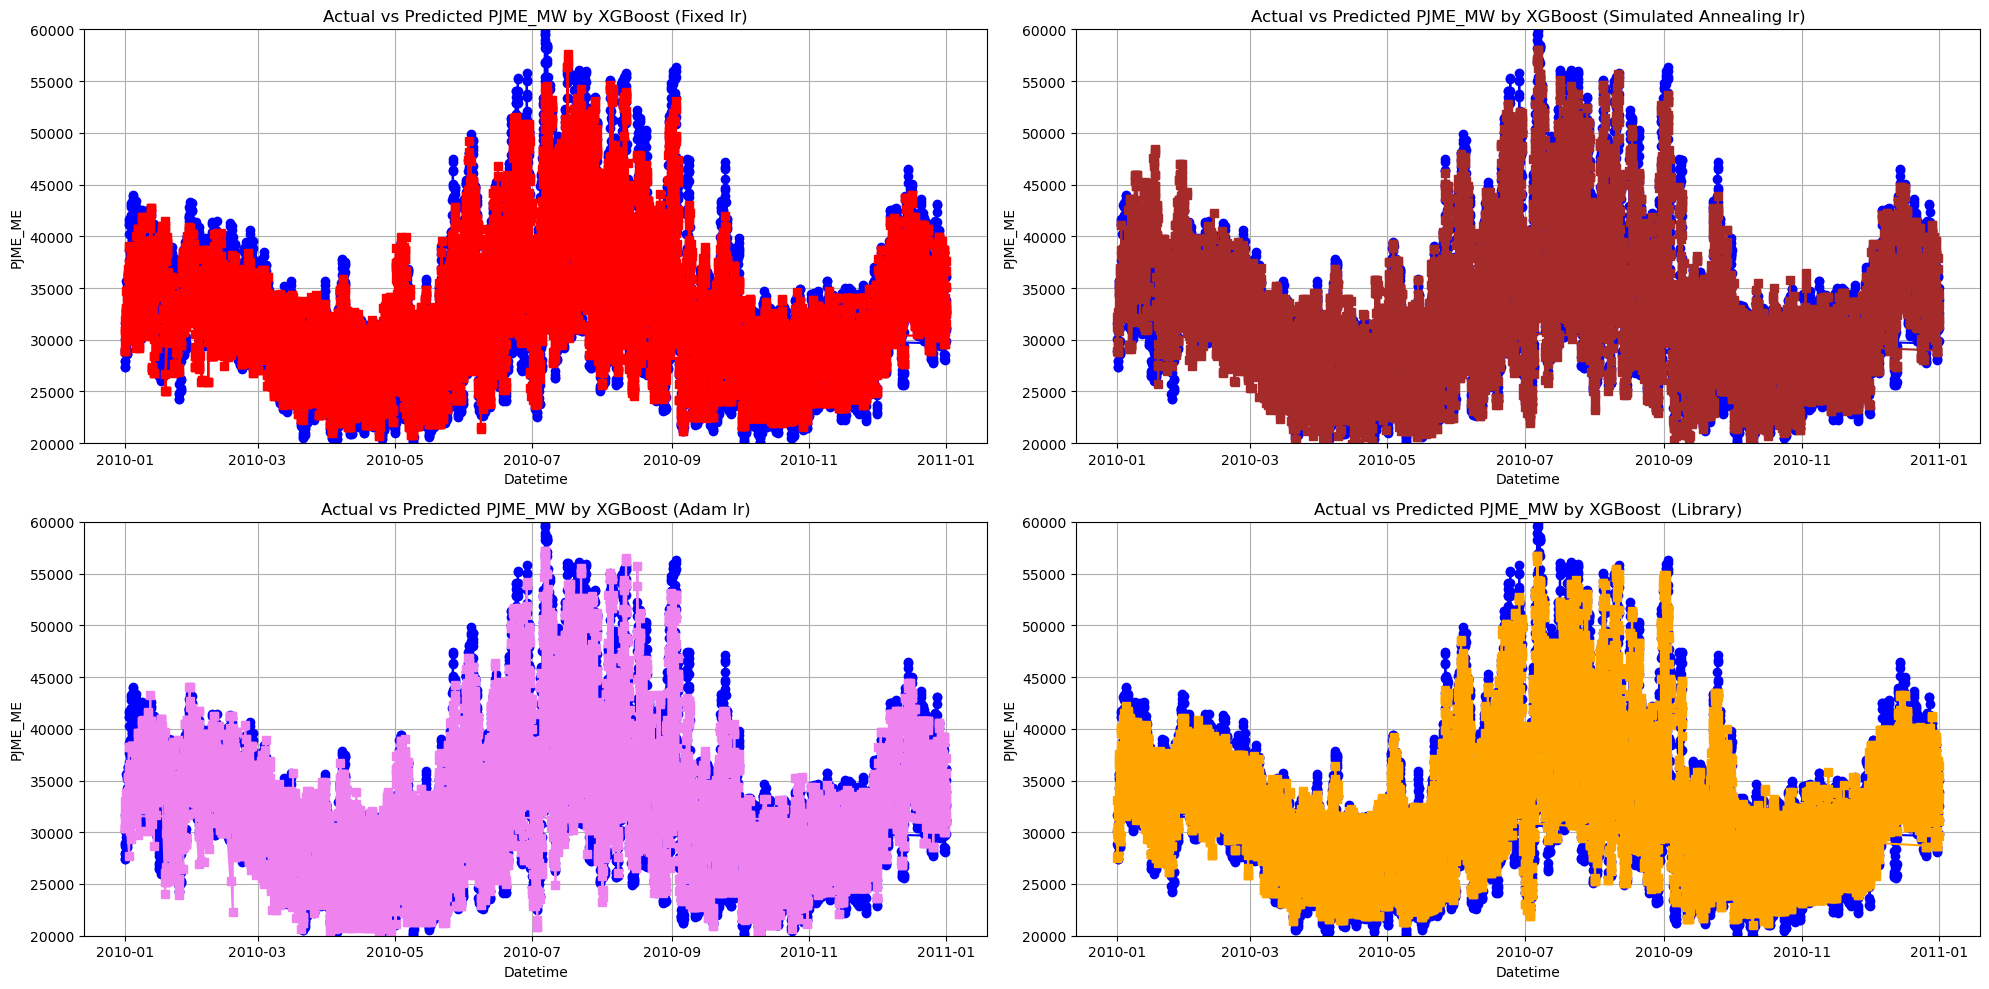

In [ ]:
with open('dataframe.pickle', 'rb') as f:
    new_df = pickle.load(f)
new_df = new_df[(new_df['Datetime'] >= '2010-01') & (new_df['Datetime'] <= '2011-01')]
X = new_df.drop(columns=['PJME_MW','Datetime'])
Y = new_df['PJME_MW']


fig, axs = plt.subplots(2, 2, figsize=(20, 10))

axs[0, 0].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 0].plot(new_df['Datetime'], model_fixed.predict(X), label='predicted',color='red', marker='s')
axs[0, 0].set_ylim(20_000, 60_000)
axs[0, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Fixed lr)')
axs[0, 0].set_xlabel('Datetime')
axs[0, 0].set_ylabel('PJME_ME')
axs[0, 0].grid(True)

axs[0, 1].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[0, 1].plot(new_df['Datetime'], model_SA.predict(X), label='predicted',color='brown', marker='s')
axs[0, 1].set_ylim(20_000, 60_000)
axs[0, 1].set_title('Actual vs Predicted PJME_MW by XGBoost (Simulated Annealing lr)')
axs[0, 1].set_xlabel('Datetime')
axs[0, 1].set_ylabel('PJME_ME')
axs[0, 1].grid(True)

axs[1, 0].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 0].plot(new_df['Datetime'], model_Adam.predict(X), label='predicted',color='violet', marker='s')
axs[1, 0].set_ylim(20_000, 60_000)
axs[1, 0].set_title('Actual vs Predicted PJME_MW by XGBoost (Adam lr)')
axs[1, 0].set_xlabel('Datetime')
axs[1, 0].set_ylabel('PJME_ME')
axs[1, 0].grid(True)

axs[1, 1].plot(new_df['Datetime'], Y, label='actual',color='blue', marker='o')
axs[1, 1].plot(new_df['Datetime'], model_Lib.predict(X), label='predicted',color='orange', marker='s')
axs[1, 1].set_ylim(20_000, 60_000)
axs[1, 1].set_title('Actual vs Predicted PJME_MW by XGBoost  (Library)')
axs[1, 1].set_xlabel('Datetime')
axs[1, 1].set_ylabel('PJME_ME')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

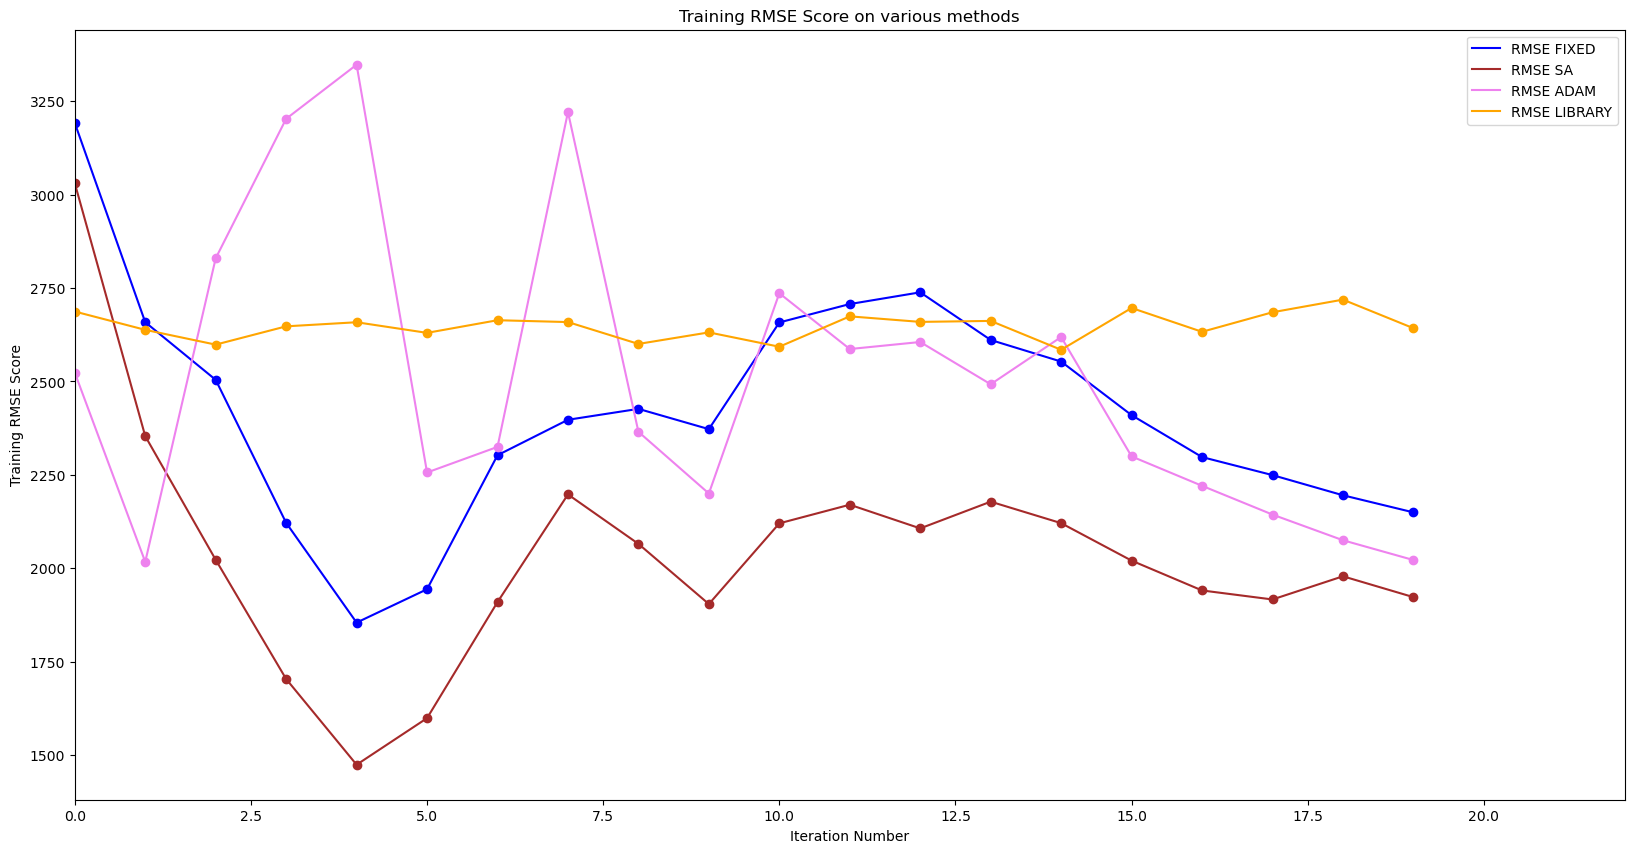

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(Rmse_Fixed, label='RMSE FIXED',color='blue')
plt.plot(Rmse_SA, label='RMSE SA',color='brown')
plt.plot(Rmse_Adam, label='RMSE ADAM',color='violet')
plt.plot(Rmse_Lib_Training, label='RMSE LIBRARY',color='orange')
plt.scatter(range(len (Rmse_Fixed)), Rmse_Fixed, color='blue')
plt.scatter(range(len (Rmse_SA)), Rmse_SA, color='brown')
plt.scatter(range(len (Rmse_Adam)), Rmse_Adam, color='violet')
plt.scatter(range(len (Rmse_Lib_Training)), Rmse_Lib_Training, color='orange')

plt.xlim(0,22)
plt.xlabel('Iteration Number')
plt.ylabel('Training RMSE Score')

plt.title('Training RMSE Score on various methods')

plt.legend()
plt.show()

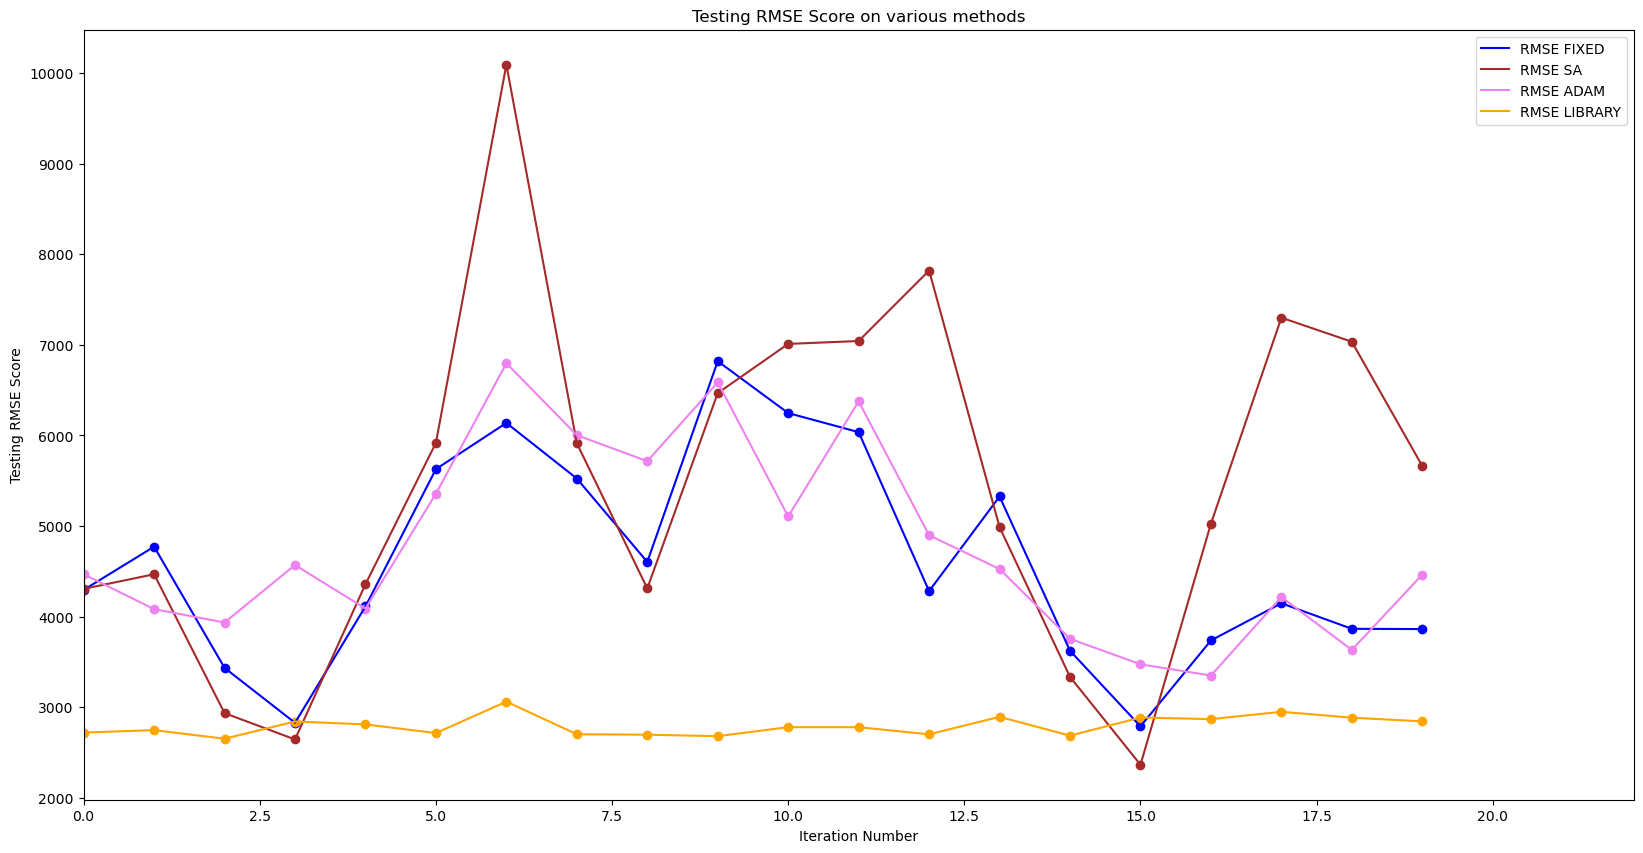

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(Rmse_Fixed_Kcross, label='RMSE FIXED',color='blue')
plt.plot(Rmse_SA_Kcross, label='RMSE SA',color='brown')
plt.plot(Rmse_Adam_Kcross, label='RMSE ADAM',color='violet')
plt.plot(Rmse_Lib_Testing, label='RMSE LIBRARY',color='orange')
plt.scatter(range(len (Rmse_Fixed_Kcross)), Rmse_Fixed_Kcross, color='blue')
plt.scatter(range(len (Rmse_SA_Kcross)), Rmse_SA_Kcross, color='brown')
plt.scatter(range(len (Rmse_Adam_Kcross)), Rmse_Adam_Kcross, color='violet')
plt.scatter(range(len (Rmse_Lib_Testing)), Rmse_Lib_Testing, color='orange')

plt.xlim(0,22)
plt.xlabel('Iteration Number')
plt.ylabel('Testing RMSE Score')

plt.title('Testing RMSE Score on various methods')

plt.legend()
plt.show()